## Imports

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import numpy as np
from datetime import datetime
import pytz
import json
import math
import warnings

# just for matplotlib, due to non recognized character
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

# config for non latin words.
# There is a Korean word: 위키백과탈퇴, which is the Korean template for Retired
# https://www.wikidata.org/wiki/Q5848674
matplotlib.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'DejaVu Sans']

## Getting the data ready to be analyzed

In [166]:
italian_wikibreaks_df = pd.read_json('../../wikidump/wikibreaks_refactored/itwiki_20210201_refactored_wikibreaks_dataset.json.gz', compression='gzip', lines=True)
# italian_wikibreaks_df.head()

Number of rows and columns

In [167]:
italian_wikibreaks_df.shape

(1396, 5)

Basic info about the Pandas dataframe

In [168]:
italian_wikibreaks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikibreaks    1396 non-null   object 
 1   id_talk_page  756 non-null    float64
 2   name          1396 non-null   object 
 3   id_user_page  902 non-null    float64
 4   ambiguous     1396 non-null   bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 45.1+ KB


Basic stats

In [169]:
italian_wikibreaks_df.describe()

,id_talk_page,id_user_page
count,7.560000e+02,9.020000e+02
mean,3.502587e+06,3.213927e+06
std,2.333624e+06,2.354995e+06
min,1.447500e+04,8.786000e+03
25%,1.607330e+06,1.229414e+06
50%,3.042408e+06,2.821192e+06
75%,5.073000e+06,4.755884e+06
max,8.770471e+06,8.814765e+06


#### Plot the graph chart to see ambiguous information retrieved

In [170]:
ambiguous_count = italian_wikibreaks_df
ambiguous_count['count'] = 1
ambiguous_count = ambiguous_count[['ambiguous', 'count']].groupby('ambiguous').count().reset_index()
ambiguous_count

,ambiguous,count
0,False,1324
1,True,72


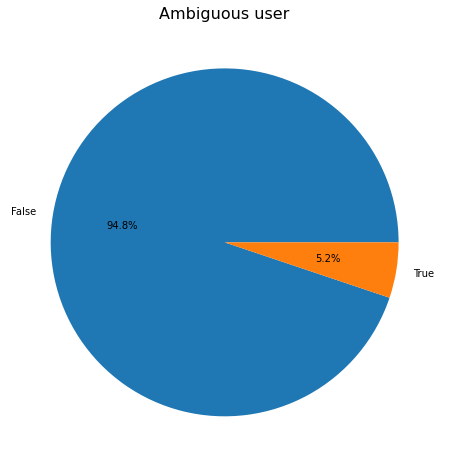

In [171]:
plt.figure(figsize=(16,8))
plt.pie(ambiguous_count['count'], labels=ambiguous_count['ambiguous'], autopct='%.1f%%')
plt.title('Ambiguous user', fontsize=16)
plt.show()

### Explicit the Wikibreaks

In [172]:
italian_wikibreaks_refactored_df = list()
# iterating over the previous dataset
for i, row in italian_wikibreaks_df.iterrows():
    # explicit the wikibreaks
    for el in row['wikibreaks']:
        new_row = row
        new_row = new_row.drop('wikibreaks')
        new_row['wikibreak'] = el['name']
        new_row['categories'] = el['categories']
        new_row['parameters'] = el['parameters']
        new_row['subcategory'] = el['subcategory']
        if el['to_date']:
            new_row['to_date'] = datetime.fromisoformat(el['to_date'])
        else:
            new_row['to_date'] = None
        new_row['from_date'] = datetime.fromisoformat(el['from_date'])
        italian_wikibreaks_refactored_df.append(new_row)
italian_wikibreaks_refactored_df = pd.DataFrame(italian_wikibreaks_refactored_df).reset_index(drop=True)
# italian_wikibreaks_refactored_df.head()

In [173]:
italian_wikibreaks_refactored_df.shape

(3595, 11)

## Remove band template, which is also present in Italian wikipedia: https://uz.wikipedia.org/wiki/Andoza:Band, which stands for busy

In [174]:
italian_wikibreaks_refactored_df = italian_wikibreaks_refactored_df[italian_wikibreaks_refactored_df['wikibreak'] != 'band']
# italian_wikibreaks_refactored_df.head()

In [175]:
italian_wikibreaks_refactored_df.shape

(3583, 11)

## Number of users still in wikibreaks or similar

In [176]:
still_in_breaks = italian_wikibreaks_refactored_df.loc[pd.isnull(italian_wikibreaks_refactored_df['to_date']), ['name', 'wikibreak', 'categories', 'subcategory']]
# still_in_breaks.head()

In [177]:
# still_in_breaks.describe()

In [178]:
users_still_in_breaks = still_in_breaks.groupby('name').count().reset_index()
# users_still_in_breaks.head()

In [179]:
users_still_in_breaks.describe()

,wikibreak,categories,subcategory
count,353.000000,353.000000,353.000000
mean,1.201133,1.201133,1.201133
std,0.609395,0.609395,0.609395
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000


## Number of users still in wikibreaks with respect to the total amount of users who specified at least a wikibreak during their wikihistory

In [180]:
italian_wikibreaks_df.shape[0]

1396

In [181]:
users_still_in_breaks.shape[0]

353

In [182]:
row_total = {'total': italian_wikibreaks_df.shape[0] - users_still_in_breaks.shape[0], 'label': 'not in break'}
row_break = {'total': users_still_in_breaks.shape[0], 'label': 'in break'}
rows = [row_total, row_break]
percentage_still_in_break = pd.DataFrame(rows).reset_index(drop=True)
percentage_still_in_break

,total,label
0,1043,not in break
1,353,in break


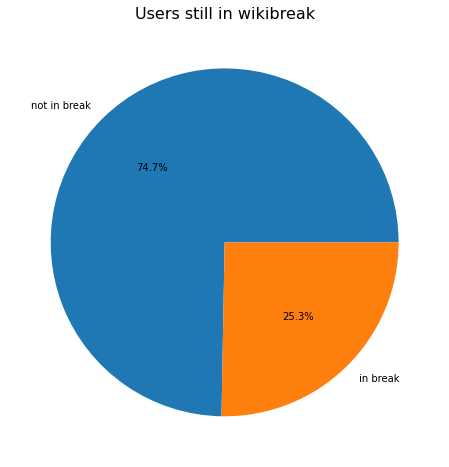

In [183]:
plt.figure(figsize=(16,8))
plt.pie(percentage_still_in_break['total'], labels=percentage_still_in_break['label'], autopct='%.1f%%')
plt.title('Users still in wikibreak', fontsize=16)
plt.show()

## Current wikibreaks templates

In [184]:
wikibreaks_still_in_breaks = still_in_breaks
wikibreaks_still_in_breaks['count'] = 1
wikibreaks_still_in_breaks = wikibreaks_still_in_breaks[['wikibreak', 'count']].groupby('wikibreak').count().reset_index()
wikibreaks_still_in_breaks.head()

,wikibreak,count
0,busy,1
1,esami,16
2,exams,1
3,malattia scherzo,10
4,occupato,135


In [185]:
wikibreaks_still_in_breaks.shape

(16, 2)

In [186]:
wikibreaks_still_in_breaks.describe()

,count
count,16.000000
mean,26.500000
std,34.571665
min,1.000000
25%,3.750000
50%,17.000000
75%,31.250000
max,135.000000


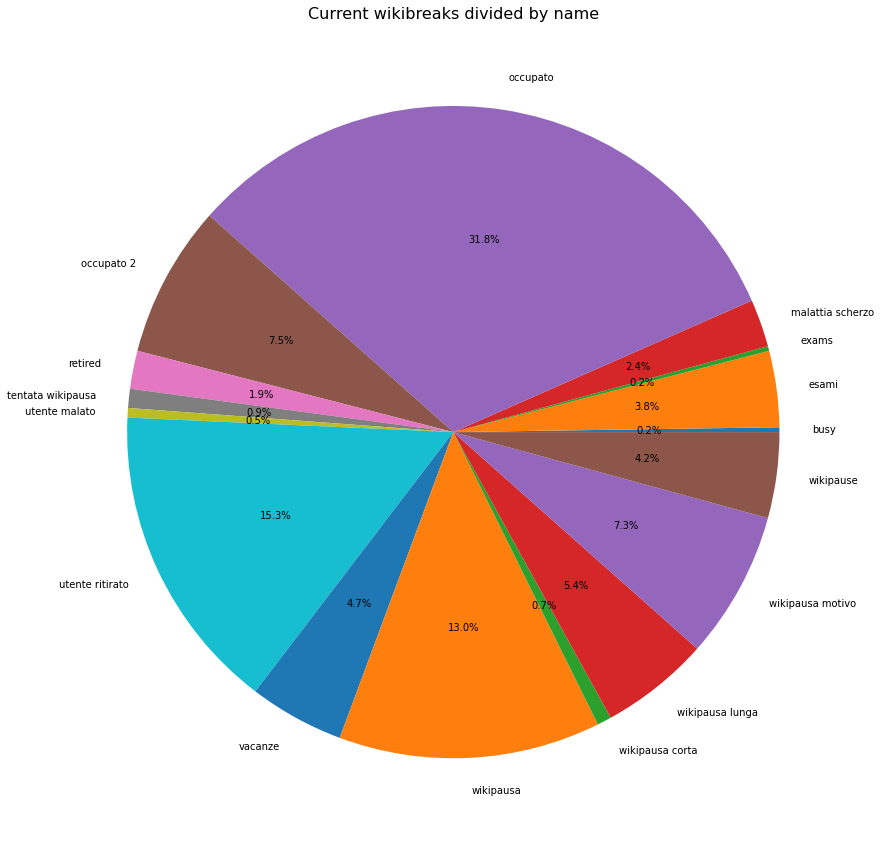

In [187]:
plt.figure(figsize=(19,15))
plt.pie(wikibreaks_still_in_breaks['count'], labels=wikibreaks_still_in_breaks['wikibreak'], autopct='%.1f%%')
plt.title('Current wikibreaks divided by name', fontsize=16)
plt.show()

## Current subcategories

In [188]:
subcategories_still_in_breaks = still_in_breaks
subcategories_still_in_breaks['count'] = 1
subcategories_still_in_breaks = subcategories_still_in_breaks[['subcategory', 'count']].groupby('subcategory').count().reset_index().sort_values(['count'], ascending=False)
subcategories_still_in_breaks.head()

,subcategory,count
0,busy,168
6,wikibreak,134
2,retired,73
5,vacation,20
1,exams,17


In [189]:
subcategories_still_in_breaks.shape

(7, 2)

In [190]:
subcategories_still_in_breaks.describe()

,count
count,7.000000
mean,60.571429
std,66.607950
min,2.000000
25%,13.500000
50%,20.000000
75%,103.500000
max,168.000000


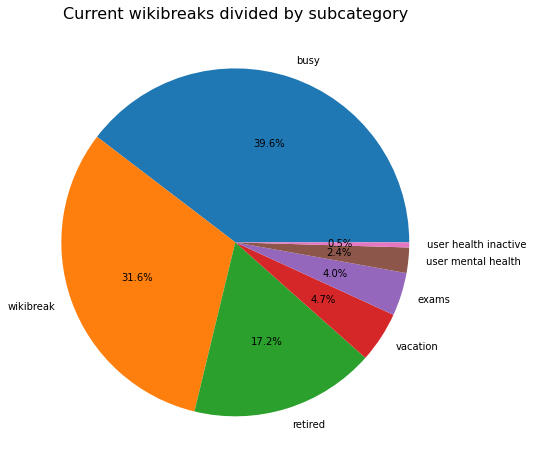

In [191]:
plt.figure(figsize=(16,8))
plt.pie(subcategories_still_in_breaks['count'], labels=subcategories_still_in_breaks['subcategory'], autopct='%.1f%%')
plt.title('Current wikibreaks divided by subcategory', fontsize=16)
plt.show()

## Current categories

In [192]:
categories_still_in_breaks = still_in_breaks[['categories', 'name']]
categories_still_in_breaks_refactored = list()
for i, row in categories_still_in_breaks.iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        categories_still_in_breaks_refactored.append(new_row)
categories_still_in_breaks_refactored = pd.DataFrame(categories_still_in_breaks_refactored).reset_index(drop=True)
# categories_still_in_breaks_refactored.head()

In [193]:
categories_still_in_breaks_refactored = categories_still_in_breaks_refactored
categories_still_in_breaks_refactored['count'] = 1
categories_still_in_breaks_refactored = categories_still_in_breaks_refactored[['category', 'count']].groupby('category').count().reset_index().sort_values(['count'], ascending=False)
categories_still_in_breaks_refactored.head()

,category,count
2,mental,178
0,break,171
3,other,73
1,health related,12


In [194]:
categories_still_in_breaks_refactored.shape

(4, 2)

In [195]:
categories_still_in_breaks_refactored.describe()

,count
count,4.000000
mean,108.500000
std,80.226762
min,12.000000
25%,57.750000
50%,122.000000
75%,172.750000
max,178.000000


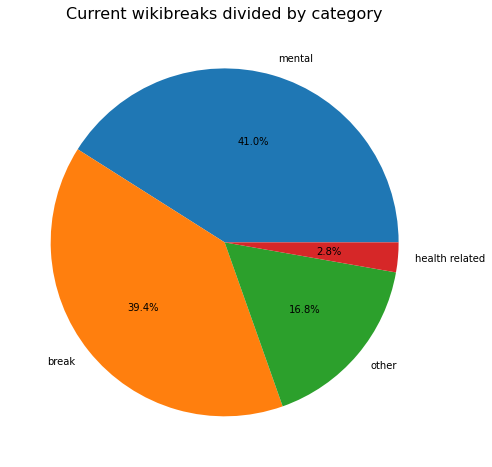

In [196]:
plt.figure(figsize=(16,8))
plt.pie(categories_still_in_breaks_refactored['count'], labels=categories_still_in_breaks_refactored['category'], autopct='%.1f%%')
plt.title('Current wikibreaks divided by category', fontsize=16)
plt.show()

# Line graph to see the flow of wikibreaks in Italian Wikipedia

In [197]:
# unique wikibreaks
# THE NON RENDERING FONT IS https://www.wikidata.org/wiki/Q5848674
wikibreaks = italian_wikibreaks_refactored_df['wikibreak'].unique()
wikibreaks

array(['esami', 'wikipausa motivo', 'wikipausa', 'vacanze',
       'utente ritirato', 'wikipause', 'occupato', 'wikipausa corta',
       'malattia scherzo', 'retired', 'wikipausa lunga', 'occupato 2',
       '위키백과탈퇴', 'tentata wikipausa', 'exams', 'utente malato',
       'wikibreak', 'busy', 'dead', 'semi-retired'], dtype=object)

In [198]:
# unique subcategories
subcategories = italian_wikibreaks_refactored_df['subcategory'].unique()
subcategories

array(['exams', 'wikibreak', 'vacation', 'retired', 'busy',
       'user mental health', 'user health inactive',
       'deceased wikipedian', 'semi-retired'], dtype=object)

In [199]:
# unique categories
categories = list()
for i, row in italian_wikibreaks_refactored_df[['categories', 'name']].iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        categories.append(new_row)
categories = pd.DataFrame(categories).reset_index(drop=True)
categories = categories['category'].unique()
categories

array(['break', 'other', 'mental', 'health related'], dtype=object)

In [200]:
# date to start from
start_from = italian_wikibreaks_refactored_df['from_date'].min()
start_from

Timestamp('2006-05-26 19:49:28+0000', tz='UTC')

In [201]:
last_date = datetime.now().replace(tzinfo=pytz.UTC)
last_date

datetime.datetime(2021, 4, 22, 12, 19, 48, 106240, tzinfo=<UTC>)

In [202]:
breaks_history = list()
italian_wikibreaks_simple_date = italian_wikibreaks_refactored_df
italian_wikibreaks_simple_date['from_date'] = italian_wikibreaks_simple_date['from_date'].dt.normalize()
italian_wikibreaks_simple_date['from_date'] = italian_wikibreaks_simple_date['from_date'].apply(lambda r: r.replace(day=1))
italian_wikibreaks_simple_date['to_date'] = italian_wikibreaks_simple_date['to_date'].dt.normalize()
italian_wikibreaks_simple_date['to_date'] = italian_wikibreaks_simple_date['to_date'].apply(lambda r: r.replace(day=1))
# iterating over years
for year in range(start_from.year, last_date.year + 1):
    if year == start_from.year: # first year
        start_month = start_from.month
    else:
        start_month = 1
    
    if year == last_date.year: # last year
        last_month = last_date.month
    else:
        last_month = 12
    
    for month in range(start_month, last_month + 1):
        mask = (italian_wikibreaks_simple_date['from_date'] <= datetime(year, month, 1).replace(tzinfo=pytz.UTC))
        mask_2 = (pd.isnull(italian_wikibreaks_simple_date['to_date'])) | (italian_wikibreaks_simple_date['to_date'] >= datetime(year, month, 1).replace(tzinfo=pytz.UTC)) 
        mask = mask & mask_2
        filtered = italian_wikibreaks_simple_date[mask]
        for j, elem in filtered.iterrows():
            el = dict()
            el['year'] = year
            el['month'] = month
            el['subcategory'] = elem['subcategory']
            el['wikibreak'] = elem['wikibreak']
            el['categories'] = elem['categories']
            breaks_history.append(el)
breaks_history = pd.DataFrame(breaks_history).reset_index(drop=True)
breaks_history.head()

,year,month,subcategory,wikibreak,categories
0,2006,5,user mental health,malattia scherzo,"[health related, mental]"
1,2006,6,wikibreak,wikipause,[break]
2,2006,6,wikibreak,wikipause,[break]
3,2006,6,wikibreak,wikipause,[break]
4,2006,6,exams,esami,[break]


In [203]:
breaks_history.shape

(45465, 5)

In [204]:
breaks_history.describe()

,year,month
count,45465.000000,45465.000000
mean,2015.340592,6.496206
std,3.760103,3.443447
min,2006.000000,1.000000
25%,2013.000000,3.000000
50%,2016.000000,7.000000
75%,2019.000000,9.000000
max,2021.000000,12.000000


In [205]:
breaks_history_subcategory_count = breaks_history
breaks_history_subcategory_count['count'] = 1
breaks_history_subcategory_count = breaks_history_subcategory_count[['year', 'month', 'subcategory', 'count']].groupby(['year', 'month',  'subcategory']).count().reset_index().sort_values(['year', 'month'], ascending=True)
breaks_history_subcategory_count['date'] = pd.to_datetime(breaks_history_subcategory_count[['year','month']].assign(day=1)).dt.date
breaks_history_subcategory_count.head()

,year,month,subcategory,count,date
0,2006,5,user mental health,1,2006-05-01
1,2006,6,busy,4,2006-06-01
2,2006,6,exams,5,2006-06-01
3,2006,6,user mental health,1,2006-06-01
4,2006,6,wikibreak,6,2006-06-01


In [206]:
breaks_history_subcategory_count.tail()

,year,month,subcategory,count,date
1116,2021,4,retired,73,2021-04-01
1117,2021,4,user health inactive,2,2021-04-01
1118,2021,4,user mental health,10,2021-04-01
1119,2021,4,vacation,20,2021-04-01
1120,2021,4,wikibreak,134,2021-04-01


In [207]:
breaks_history_subcategory_count.describe()

,year,month,count
count,1121.000000,1121.000000,1121.000000
mean,2013.934880,6.487065,40.557538
std,4.207375,3.460757,46.258267
min,2006.000000,1.000000,1.000000
25%,2011.000000,3.000000,10.000000
50%,2014.000000,6.000000,19.000000
75%,2018.000000,9.000000,59.000000
max,2021.000000,12.000000,180.000000


#### Clean counter

In [208]:
breaks_history_subcategory_count_cleaned = list()
for date in breaks_history_subcategory_count['date'].unique():
    for subcat in subcategories:
        elem = breaks_history_subcategory_count.loc[(breaks_history_subcategory_count['date'] == date) & (breaks_history_subcategory_count['subcategory'] == subcat)]
        if elem.empty:
            breaks_history_subcategory_count_cleaned.append([date.year, date.month, subcat, 0, date])
        else:
            breaks_history_subcategory_count_cleaned.append(np.array(elem)[0])
breaks_history_subcategory_count_cleaned = pd.DataFrame(breaks_history_subcategory_count_cleaned).reset_index(drop=True).set_axis(['year', 'month', 'subcategory', 'count', 'date'], axis=1)
breaks_history_subcategory_count_cleaned.head()

,year,month,subcategory,count,date
0,2006,5,exams,0,2006-05-01
1,2006,5,wikibreak,0,2006-05-01
2,2006,5,vacation,0,2006-05-01
3,2006,5,retired,0,2006-05-01
4,2006,5,busy,0,2006-05-01


## Subcategories during Italian Wikipedia history

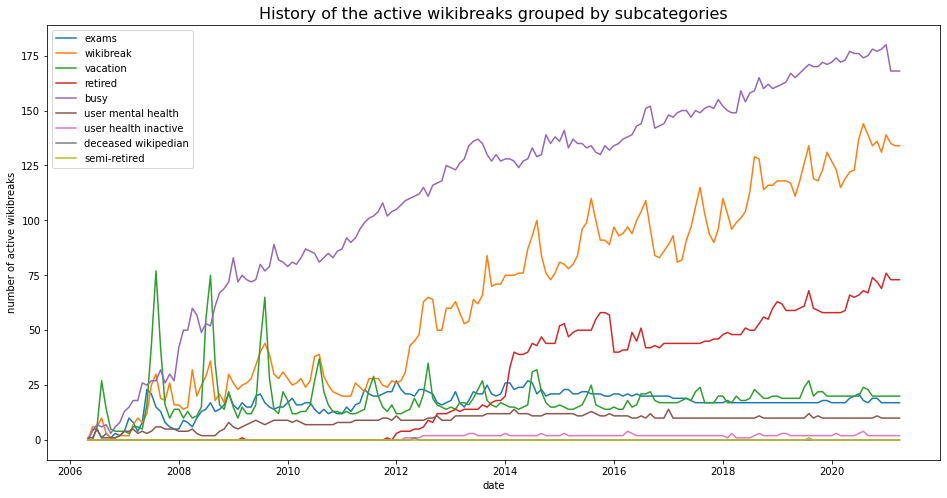

In [209]:
plt.figure(figsize=(16,8))
for subcategory in breaks_history_subcategory_count_cleaned['subcategory'].unique():
    subcat = breaks_history_subcategory_count_cleaned[breaks_history_subcategory_count_cleaned['subcategory'] == subcategory]
    plt.plot(subcat['date'], subcat['count'], label = subcategory)
plt.legend()
plt.title('History of the active wikibreaks grouped by subcategories', fontsize=16)
plt.ylabel('number of active wikibreaks')
plt.xlabel('date')
plt.show()

In [210]:
fig = px.line(breaks_history_subcategory_count_cleaned, x='date', y='count', color='subcategory', title='History of the active wikibreaks grouped by subcategories')
fig.show()

The same but with the names of the pauses

In [211]:
breaks_history_wikibreak_count = breaks_history
breaks_history_wikibreak_count['count'] = 1
breaks_history_wikibreak_count = breaks_history_wikibreak_count[['year', 'month', 'wikibreak', 'count']].groupby(['year', 'month', 'wikibreak']).count().reset_index().sort_values(['year', 'month'], ascending=True)
breaks_history_wikibreak_count['date'] = pd.to_datetime(breaks_history_wikibreak_count[['year','month']].assign(day=1)).dt.date
breaks_history_wikibreak_count.head()

,year,month,wikibreak,count,date
0,2006,5,malattia scherzo,1,2006-05-01
1,2006,6,esami,5,2006-06-01
2,2006,6,malattia scherzo,1,2006-06-01
3,2006,6,occupato,4,2006-06-01
4,2006,6,wikipause,6,2006-06-01


In [212]:
breaks_history_wikibreak_count.tail()

,year,month,wikibreak,count,date
2176,2021,4,wikipausa,55,2021-04-01
2177,2021,4,wikipausa corta,3,2021-04-01
2178,2021,4,wikipausa lunga,23,2021-04-01
2179,2021,4,wikipausa motivo,31,2021-04-01
2180,2021,4,wikipause,18,2021-04-01


In [213]:
breaks_history_wikibreak_count.describe()

,year,month,count
count,2181.000000,2181.000000,2181.000000
mean,2014.771206,6.465841,20.845942
std,3.900414,3.462956,28.874898
min,2006.000000,1.000000,1.000000
25%,2012.000000,3.000000,3.000000
50%,2015.000000,6.000000,13.000000
75%,2018.000000,9.000000,23.000000
max,2021.000000,12.000000,146.000000


#### Clean counter

In [214]:
breaks_history_wikibreak_count_cleaned = list()
for date in breaks_history_wikibreak_count['date'].unique():
    for wb in wikibreaks:
        elem = breaks_history_wikibreak_count.loc[(breaks_history_wikibreak_count['date'] == date) & (breaks_history_wikibreak_count['wikibreak'] == wb)]
        if elem.empty:
            breaks_history_wikibreak_count_cleaned.append([date.year, date.month, wb, 0, date])
        else:
            breaks_history_wikibreak_count_cleaned.append(np.array(elem)[0])
breaks_history_wikibreak_count_cleaned = pd.DataFrame(breaks_history_wikibreak_count_cleaned).reset_index(drop=True).set_axis(['year', 'month', 'wikibreak', 'count', 'date'], axis=1)
breaks_history_wikibreak_count_cleaned.head()

,year,month,wikibreak,count,date
0,2006,5,esami,0,2006-05-01
1,2006,5,wikipausa motivo,0,2006-05-01
2,2006,5,wikipausa,0,2006-05-01
3,2006,5,vacanze,0,2006-05-01
4,2006,5,utente ritirato,0,2006-05-01


## Wikibreaks during Italian Wikipedia history

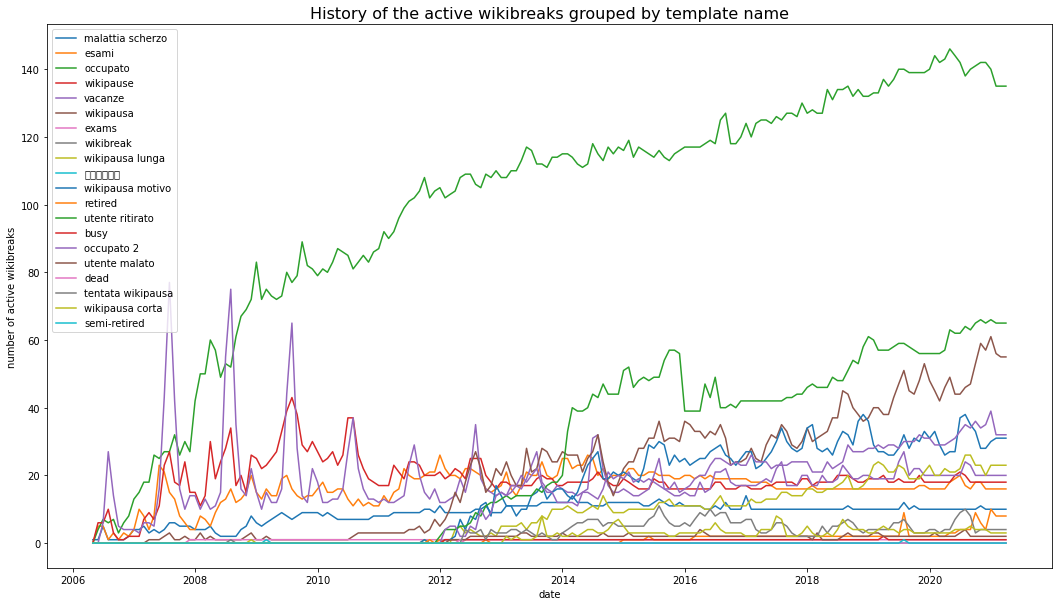

In [215]:
plt.figure(figsize=(18,10))
for wikibreak in breaks_history_wikibreak_count['wikibreak'].unique():
    wb = breaks_history_wikibreak_count_cleaned[breaks_history_wikibreak_count_cleaned['wikibreak'] == wikibreak]
    plt.plot(wb['date'], wb['count'], label = wikibreak)
plt.legend()
plt.title('History of the active wikibreaks grouped by template name', fontsize=16)
plt.ylabel('number of active wikibreaks')
plt.xlabel('date')
plt.show()

In [216]:
fig = px.line(breaks_history_wikibreak_count_cleaned, x='date', y='count', color='wikibreak', title='History of the active wikibreaks grouped by template name')
fig.show()

In [217]:
breaks_history_category_count = breaks_history[['year', 'month', 'subcategory', 'categories']]
breaks_history_category_count.head()

,year,month,subcategory,categories
0,2006,5,user mental health,"[health related, mental]"
1,2006,6,wikibreak,[break]
2,2006,6,wikibreak,[break]
3,2006,6,wikibreak,[break]
4,2006,6,exams,[break]


In [218]:
breaks_history_category_count_refactored = list()
for i, row in breaks_history_category_count.iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        breaks_history_category_count_refactored.append(new_row)
breaks_history_category_count_refactored = pd.DataFrame(breaks_history_category_count_refactored).reset_index(drop=True)
breaks_history_category_count_refactored.head()

,year,month,subcategory,category
0,2006,5,user mental health,health related
1,2006,5,user mental health,mental
2,2006,6,wikibreak,break
3,2006,6,wikibreak,break
4,2006,6,wikibreak,break


In [219]:
breaks_history_category_count_refactored = breaks_history_category_count_refactored
breaks_history_category_count_refactored['count'] = 1
breaks_history_category_count_refactored = breaks_history_category_count_refactored[['year', 'month', 'category', 'count']].groupby(['year', 'month', 'category']).count().reset_index().sort_values(['year', 'month'], ascending=True)
breaks_history_category_count_refactored['date'] = pd.to_datetime(breaks_history_category_count_refactored[['year','month']].assign(day=1)).dt.date
breaks_history_category_count_refactored.head()

,year,month,category,count,date
0,2006,5,health related,1,2006-05-01
1,2006,5,mental,1,2006-05-01
2,2006,6,break,11,2006-06-01
3,2006,6,health related,1,2006-06-01
4,2006,6,mental,5,2006-06-01


In [220]:
breaks_history_category_count_refactored.tail()

,year,month,category,count,date
648,2021,3,other,73,2021-03-01
649,2021,4,break,171,2021-04-01
650,2021,4,health related,12,2021-04-01
651,2021,4,mental,178,2021-04-01
652,2021,4,other,73,2021-04-01


In [221]:
breaks_history_category_count_refactored.shape

(653, 5)

In [222]:
breaks_history_wikibreak_count.describe()

,year,month,count
count,2181.000000,2181.000000,2181.000000
mean,2014.771206,6.465841,20.845942
std,3.900414,3.462956,28.874898
min,2006.000000,1.000000,1.000000
25%,2012.000000,3.000000,3.000000
50%,2015.000000,6.000000,13.000000
75%,2018.000000,9.000000,23.000000
max,2021.000000,12.000000,146.000000


#### Clean counter

In [223]:
breaks_history_category_count_refactored_cleaned = list()
for date in breaks_history_category_count_refactored['date'].unique():
    for cat in categories:
        elem = breaks_history_category_count_refactored.loc[(breaks_history_category_count_refactored['date'] == date) & (breaks_history_category_count_refactored['category'] == cat)]
        if elem.empty:
            breaks_history_category_count_refactored_cleaned.append([date.year, date.month, cat, 0, date])
        else:
            breaks_history_category_count_refactored_cleaned.append(np.array(elem)[0])
breaks_history_category_count_refactored_cleaned = pd.DataFrame(breaks_history_category_count_refactored_cleaned).reset_index(drop=True).set_axis(['year', 'month', 'category', 'count', 'date'], axis=1)
breaks_history_category_count_refactored_cleaned.head()

,year,month,category,count,date
0,2006,5,break,0,2006-05-01
1,2006,5,other,0,2006-05-01
2,2006,5,mental,1,2006-05-01
3,2006,5,health related,1,2006-05-01
4,2006,6,break,11,2006-06-01


## Categories during Italian Wikipedia history

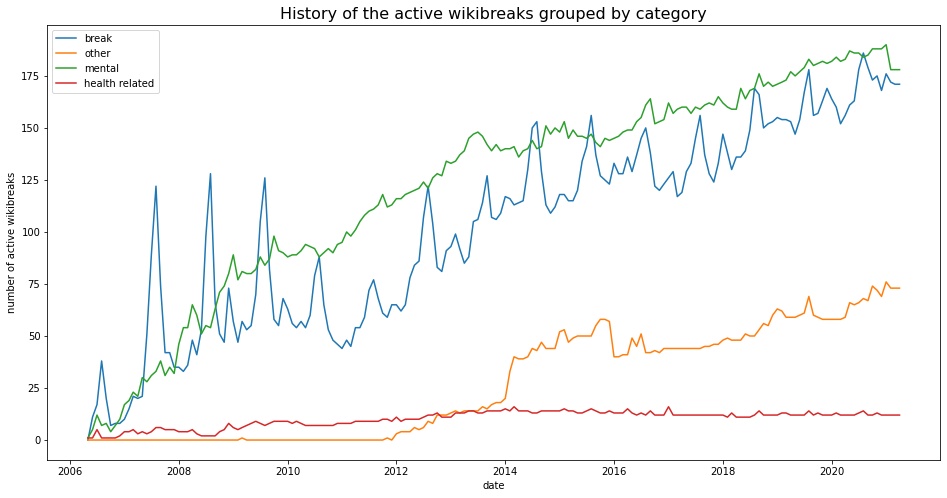

In [224]:
plt.figure(figsize=(16,8))
for cat in breaks_history_category_count_refactored_cleaned['category'].unique():
    category = breaks_history_category_count_refactored_cleaned[breaks_history_category_count_refactored_cleaned['category'] == cat]
    plt.plot(category['date'], category['count'], label = cat)
plt.legend()
plt.title('History of the active wikibreaks grouped by category', fontsize=16)
plt.ylabel('number of active wikibreaks')
plt.xlabel('date')
plt.show()

In [225]:
fig = px.line(breaks_history_category_count_refactored_cleaned, x='date', y='count', color='category', title='History of the active wikibreaks grouped by category')
fig.show()

## Total number of times a certain template was used

In [226]:
# italian_wikibreaks_refactored_df.head()

In [227]:
wikibreak_used = italian_wikibreaks_refactored_df
wikibreak_used['count'] = 1
wikibreak_used = wikibreak_used[['wikibreak', 'count']].groupby('wikibreak').count().reset_index().sort_values(['count'], ascending=False)
wikibreak_used.head()

,wikibreak,count
5,occupato,724
12,vacanze,650
18,wikipause,479
14,wikipausa,450
17,wikipausa motivo,315


In [228]:
wikibreak_used.shape

(20, 2)

In [229]:
wikibreak_used.describe()

,count
count,20.000000
mean,179.150000
std,227.536064
min,1.000000
25%,1.750000
50%,73.000000
75%,258.750000
max,724.000000


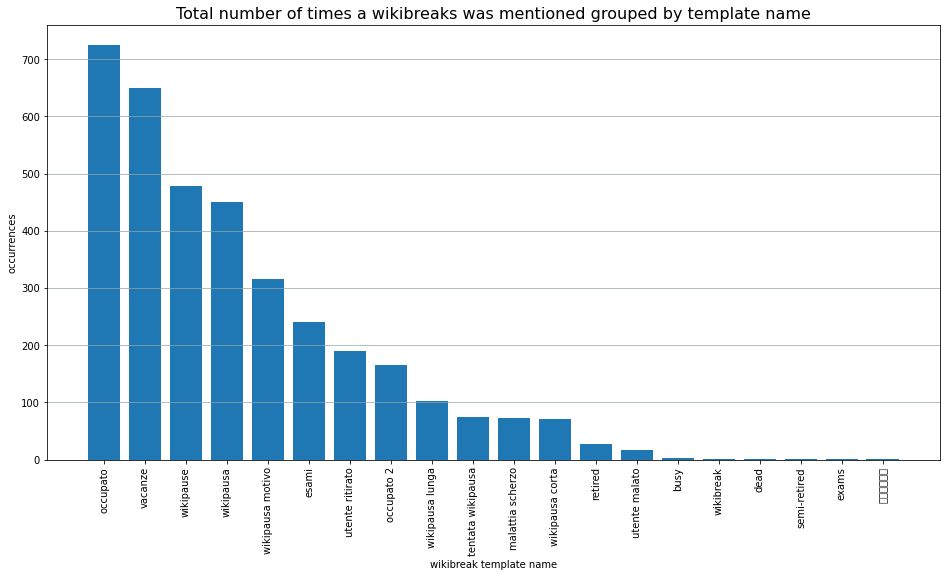

In [230]:
plt.figure(figsize=(16,8))
plt.bar(wikibreak_used['wikibreak'], wikibreak_used['count'])
plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.7)
plt.xticks(rotation='vertical')
plt.title('Total number of times a wikibreaks was mentioned grouped by template name', fontsize=16)
plt.ylabel('occurrences')
plt.xlabel('wikibreak template name')
plt.show()

# THE NON RENDERING FONT IS https://www.wikidata.org/wiki/Q5848674
# retired

## Number of time a certain subcategory was mentioned

In [231]:
subcategory_used = italian_wikibreaks_refactored_df
subcategory_used['count'] = 1
subcategory_used = subcategory_used[['subcategory', 'count']].groupby('subcategory').count().reset_index().sort_values(['count'], ascending=False)
subcategory_used.head()

,subcategory,count
8,wikibreak,1492
0,busy,891
7,vacation,650
2,exams,241
3,retired,218


In [232]:
subcategory_used.shape

(9, 2)

In [233]:
subcategory_used.describe()

,count
count,9.000000
mean,398.111111
std,515.641941
min,1.000000
25%,17.000000
50%,218.000000
75%,650.000000
max,1492.000000


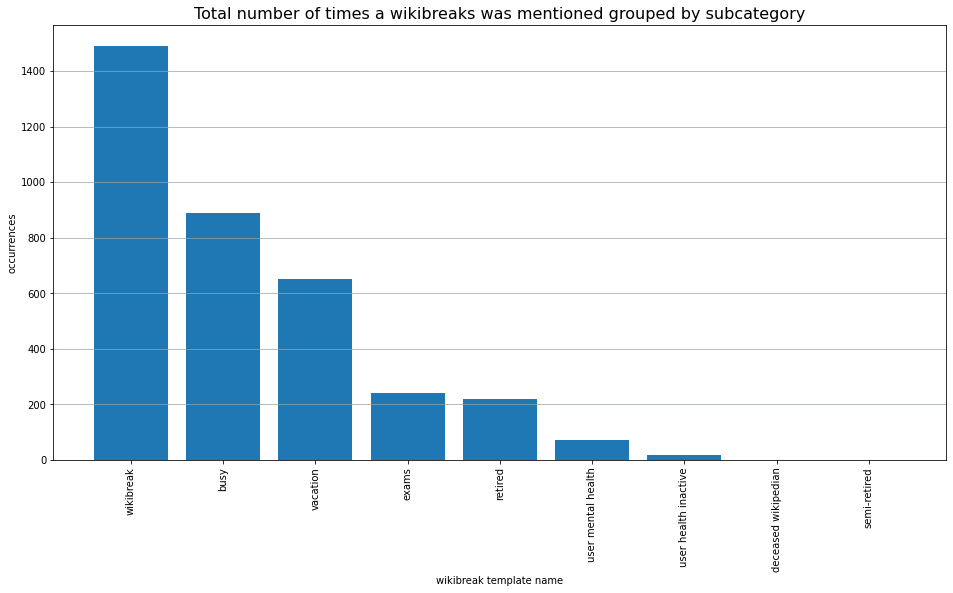

In [234]:
plt.figure(figsize=(16,8))
plt.bar(subcategory_used['subcategory'], subcategory_used['count'])
plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.7)
plt.title('Total number of times a wikibreaks was mentioned grouped by subcategory', fontsize=16)
plt.xticks(rotation='vertical')
plt.ylabel('occurrences')
plt.xlabel('wikibreak template name')
plt.show()

## Number of time a certain category was mentioned

In [235]:
category_used = still_in_breaks[['categories', 'name']]
category_used = list()
for i, row in italian_wikibreaks_refactored_df.iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        category_used.append(new_row)
category_used = pd.DataFrame(category_used).reset_index(drop=True)
# category_used.head()

In [236]:
category_used['count'] = 1
category_used = category_used[['category', 'count']].groupby('category').count().reset_index().sort_values(['count'], ascending=False)
category_used.head()

,category,count
0,break,2383
2,mental,963
3,other,220
1,health related,89


In [237]:
category_used.shape

(4, 2)

In [238]:
category_used.describe()

,count
count,4.000000
mean,913.750000
std,1052.397699
min,89.000000
25%,187.250000
50%,591.500000
75%,1318.000000
max,2383.000000


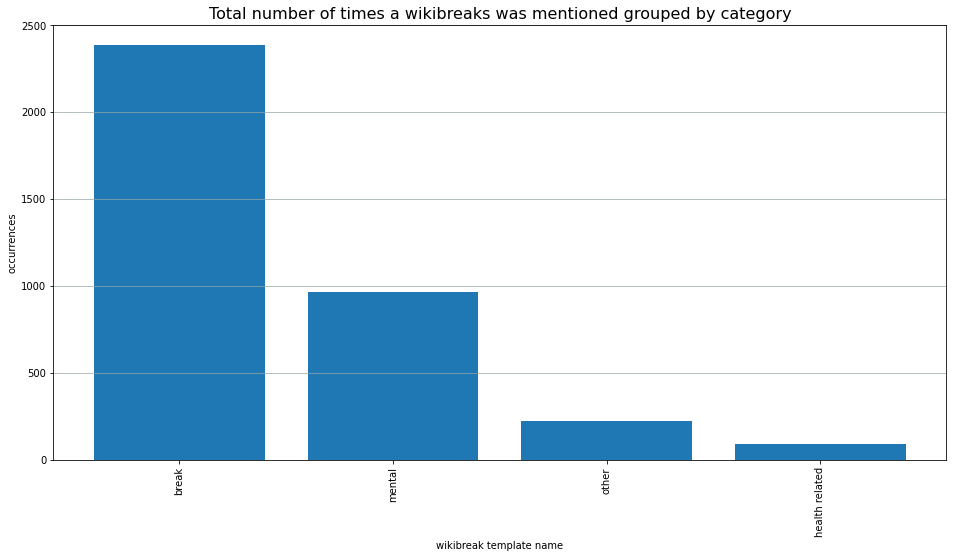

In [239]:
plt.figure(figsize=(16,8))
plt.bar(category_used['category'], category_used['count'])
plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.7)
plt.xticks(rotation='vertical')
plt.title('Total number of times a wikibreaks was mentioned grouped by category', fontsize=16)
plt.ylabel('occurrences')
plt.xlabel('wikibreak template name')
plt.show()

 ## Number of users who went multiples times in wikibreak (using the same template)

In [240]:
# italian_wikibreaks_refactored_df.head()

In [241]:
users_multiple_times_wikibreak = italian_wikibreaks_refactored_df
users_multiple_times_wikibreak['count'] = 1
# users_multiple_times_wikibreak.head()

In [242]:
users_multiple_times_wikibreak = users_multiple_times_wikibreak[['name', 'wikibreak', 'count']].groupby(['name', 'wikibreak']).count().reset_index()
# users_multiple_times_wikibreak.head()

In [243]:
total_users = italian_wikibreaks_df.shape[0]
total_users

1396

In [244]:
users_multiple_times_wikibreak = users_multiple_times_wikibreak.loc[users_multiple_times_wikibreak['count'] >= 2]
# users_multiple_times_wikibreak.head()

In [245]:
total_users_multiple = users_multiple_times_wikibreak.shape[0]
total_users_multiple

679

In [246]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_users_multiple, 'label': 'single time'}
row_multiple = {'total': total_users_multiple, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,717,single time
1,679,multiple times


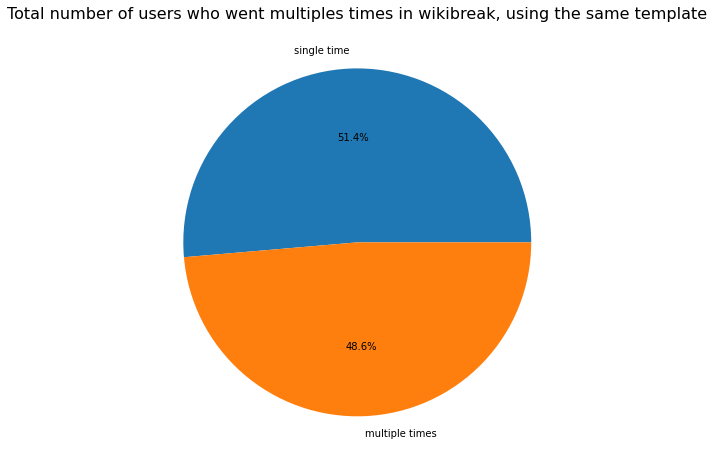

In [247]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using the same template', fontsize=16)
plt.show()

### Remove ambiguous users 

In [248]:
users_multiple_times_wikibreak_not_ambiguous = italian_wikibreaks_refactored_df
users_multiple_times_wikibreak_not_ambiguous = users_multiple_times_wikibreak_not_ambiguous.loc[users_multiple_times_wikibreak_not_ambiguous['ambiguous'] == False, ['name', 'wikibreak']]
users_multiple_times_wikibreak_not_ambiguous['count'] = 1
# users_multiple_times_wikibreak_not_ambiguous.head()

In [249]:
users_multiple_times_wikibreak_not_ambiguous.shape

(3023, 3)

In [250]:
users_multiple_times_wikibreak_not_ambiguous = users_multiple_times_wikibreak_not_ambiguous[['name', 'wikibreak', 'count']].groupby(['name', 'wikibreak']).count().reset_index()
# users_multiple_times_wikibreak_not_ambiguous.head()

In [251]:
users_multiple_times_wikibreak_not_ambiguous = users_multiple_times_wikibreak_not_ambiguous.loc[users_multiple_times_wikibreak_not_ambiguous['count'] >= 2]
# users_multiple_times_wikibreak_not_ambiguous.head()

In [252]:
total_users_multiple_wikibreak_not_ambiguous = users_multiple_times_wikibreak_not_ambiguous.shape[0]
total_users_multiple_wikibreak_not_ambiguous

556

Still over the total amount of users

In [253]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_users_multiple_wikibreak_not_ambiguous, 'label': 'single time'}
row_multiple = {'total': total_users_multiple_wikibreak_not_ambiguous, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,840,single time
1,556,multiple times


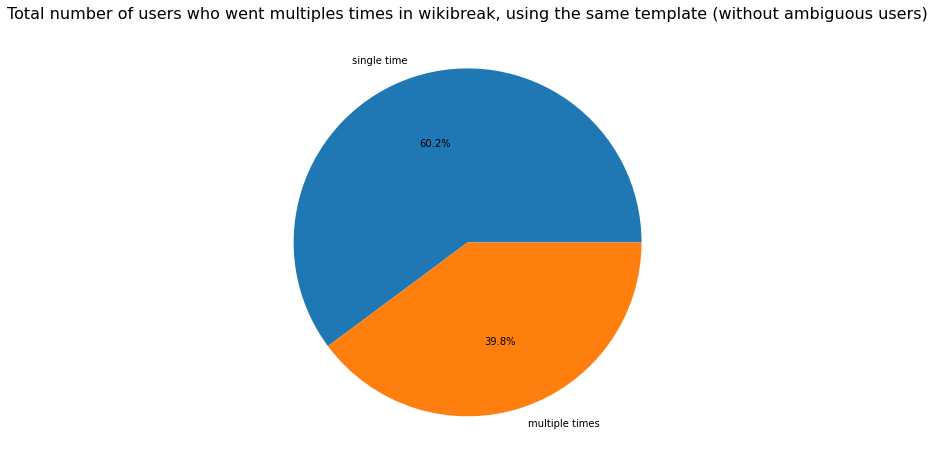

In [254]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using the same template (without ambiguous users)', fontsize=16)
plt.show()

 ## Number of users who went multiples times in wikibreak (using the same subcategory)

In [255]:
# italian_wikibreaks_refactored_df.head()

In [256]:
users_multiple_times_subcategory = italian_wikibreaks_refactored_df
users_multiple_times_subcategory['count'] = 1
# users_multiple_times_subcategory.head()

In [257]:
users_multiple_times_subcategory.shape

(3583, 11)

In [258]:
users_multiple_times_subcategory = users_multiple_times_subcategory[['name', 'subcategory', 'count']].groupby(['name', 'subcategory']).count().reset_index()
# users_multiple_times_subcategory.head()

In [259]:
users_multiple_times_subcategory = users_multiple_times_subcategory.loc[users_multiple_times_subcategory['count'] >= 2]
# users_multiple_times_subcategory.head()

In [260]:
total_users_multiple = users_multiple_times_wikibreak.shape[0]
total_users_multiple

679

In [261]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_users_multiple, 'label': 'single time'}
row_multiple = {'total': total_users_multiple, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,717,single time
1,679,multiple times


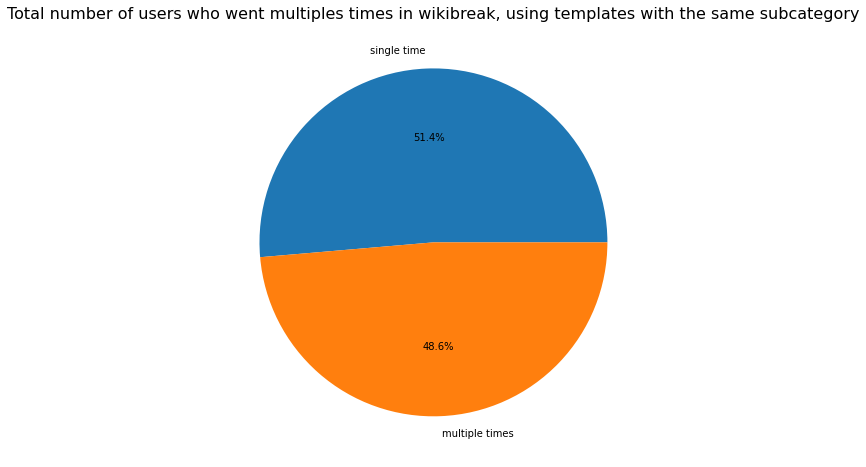

In [262]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using templates with the same subcategory', fontsize=16)
plt.show()

### Remove ambiguous users 

In [263]:
users_multiple_times_subcategory_not_ambiguous = italian_wikibreaks_refactored_df
users_multiple_times_subcategory_not_ambiguous = users_multiple_times_subcategory_not_ambiguous.loc[users_multiple_times_subcategory_not_ambiguous['ambiguous'] == False, ['name', 'subcategory']]
users_multiple_times_subcategory_not_ambiguous['count'] = 1
# users_multiple_times_subcategory_not_ambiguous.head()

In [264]:
users_multiple_times_subcategory_not_ambiguous.shape

(3023, 3)

In [265]:
users_multiple_times_subcategory_not_ambiguous = users_multiple_times_subcategory_not_ambiguous[['name', 'subcategory', 'count']].groupby(['name', 'subcategory']).count().reset_index()
# users_multiple_times_subcategory_not_ambiguous.head()

In [266]:
users_multiple_times_subcategory_not_ambiguous = users_multiple_times_subcategory_not_ambiguous.loc[users_multiple_times_subcategory_not_ambiguous['count'] >= 2]
# users_multiple_times_subcategory_not_ambiguous.head()

In [267]:
total_users_multiple_times_subcategory_not_ambiguous = users_multiple_times_subcategory_not_ambiguous.shape[0]
total_users_multiple_times_subcategory_not_ambiguous

579

Still over the total

In [268]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_users_multiple_times_subcategory_not_ambiguous, 'label': 'single time'}
row_multiple = {'total': total_users_multiple_times_subcategory_not_ambiguous, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,817,single time
1,579,multiple times


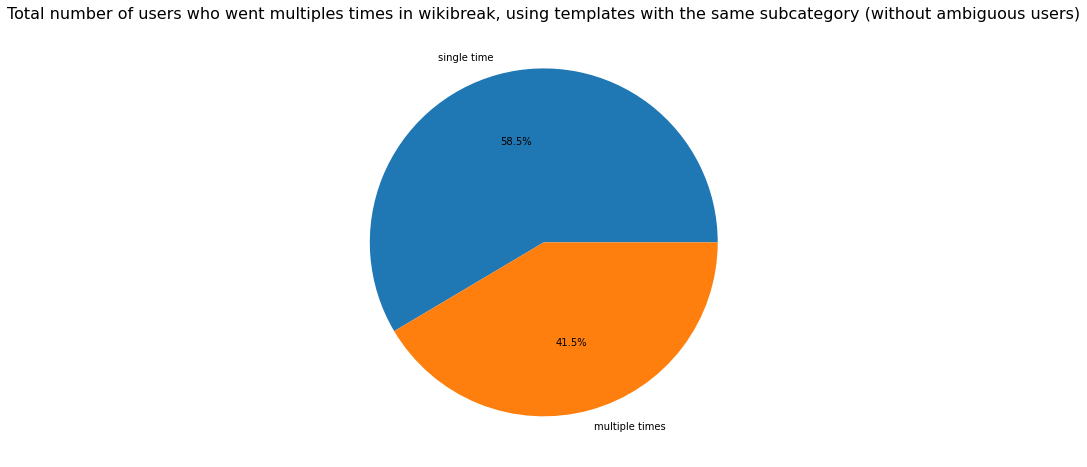

In [269]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using templates with the same subcategory (without ambiguous users)', fontsize=16)
plt.show()

 ## Number of users who went multiples times in wikibreak (using the same category)

In [270]:
# italian_wikibreaks_refactored_df.head()

#### Explicit the category

In [271]:
categories_multiple_times = italian_wikibreaks_refactored_df[['categories', 'name']]
categories_multiple_times_refactored = list()
for i, row in italian_wikibreaks_refactored_df.iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        categories_multiple_times_refactored.append(new_row)
categories_multiple_times_refactored = pd.DataFrame(categories_multiple_times_refactored).reset_index(drop=True)
# categories_multiple_times_refactored.head()

In [272]:
categories_multiple_times.shape

(3583, 2)

In [273]:
categories_multiple_times_refactored = categories_multiple_times_refactored
categories_multiple_times_refactored['count'] = 1
# categories_multiple_times_refactored.head()

In [274]:
categories_multiple_times_refactored = categories_multiple_times_refactored[['name', 'category', 'count']].groupby(['name', 'category']).count().reset_index()
# categories_multiple_times_refactored.head()

In [275]:
categories_multiple_times_refactored = categories_multiple_times_refactored.loc[categories_multiple_times_refactored['count'] >= 2]
# categories_multiple_times_refactored.head()

In [276]:
total_category_multiple = categories_multiple_times_refactored.shape[0]
total_category_multiple

675

In [277]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_category_multiple, 'label': 'single time'}
row_multiple = {'total': total_category_multiple, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,721,single time
1,675,multiple times


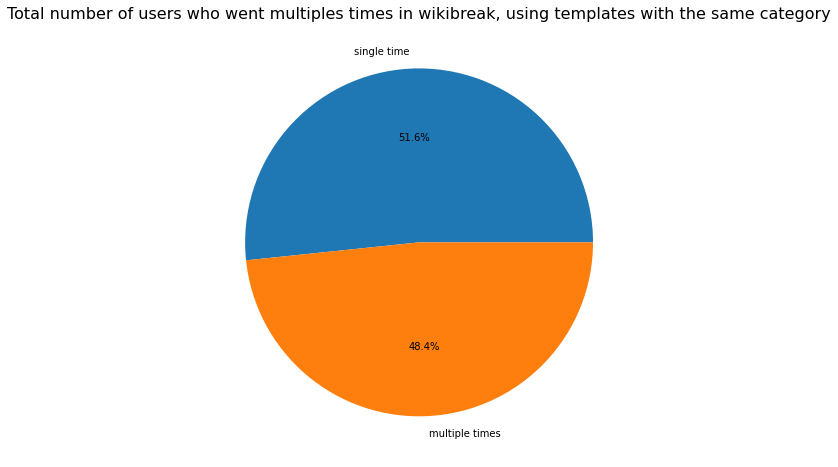

In [278]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using templates with the same category', fontsize=16)
plt.show()

### Remove ambiguous users 

In [279]:
users_multiple_times_category_not_ambiguous = italian_wikibreaks_refactored_df
users_multiple_times_category_not_ambiguous = users_multiple_times_category_not_ambiguous.loc[users_multiple_times_category_not_ambiguous['ambiguous'] == False, ['name', 'categories']]
users_multiple_times_category_not_ambiguous['count'] = 1
# users_multiple_times_category_not_ambiguous.head()

In [280]:
users_multiple_times_category_not_ambiguous_refactored = list()
for i, row in users_multiple_times_category_not_ambiguous.iterrows():
    for el in row['categories']:
        new_row = row
        new_row = new_row.drop('categories')
        new_row['category'] = el
        users_multiple_times_category_not_ambiguous_refactored.append(new_row)
users_multiple_times_category_not_ambiguous_refactored = pd.DataFrame(users_multiple_times_category_not_ambiguous_refactored).reset_index(drop=True)
# users_multiple_times_category_not_ambiguous_refactored.head()

In [281]:
users_multiple_times_category_not_ambiguous_refactored.shape

(3084, 3)

In [282]:
users_multiple_times_category_not_ambiguous_refactored = users_multiple_times_category_not_ambiguous_refactored[['name', 'category', 'count']].groupby(['name', 'category']).count().reset_index()
# users_multiple_times_category_not_ambiguous_refactored.head()

In [283]:
users_multiple_times_category_not_ambiguous_refactored = users_multiple_times_category_not_ambiguous_refactored.loc[users_multiple_times_category_not_ambiguous_refactored['count'] >= 2]
# users_multiple_times_category_not_ambiguous_refactored.head()

In [284]:
total_category_multiple_not_ambiguous = users_multiple_times_category_not_ambiguous_refactored.shape[0]
total_category_multiple_not_ambiguous

575

In [285]:
row_total = {'total': italian_wikibreaks_df.shape[0] - total_category_multiple_not_ambiguous, 'label': 'single time'}
row_multiple = {'total': total_category_multiple_not_ambiguous, 'label': 'multiple times'}
rows = [row_total, row_multiple]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times

,total,label
0,821,single time
1,575,multiple times


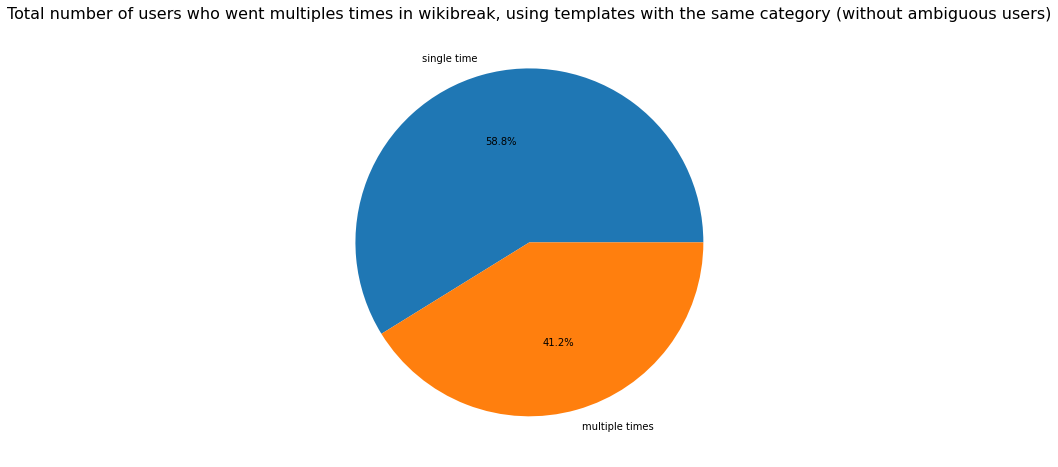

In [286]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total number of users who went multiples times in wikibreak, using templates with the same category (without ambiguous users)', fontsize=16)

plt.show()

# Parameters analysis

In [287]:
# italian_wikibreaks_refactored_df.head()

## Explicit the parameters associated with the wikibreak considering each wikibreak of each user

In [288]:
parameters_explicited = list()
for i, row in italian_wikibreaks_refactored_df.iterrows():
    for el in row['parameters']:
        new_row = row
        new_row = new_row.drop('parameters')
        new_row['parameters'] = el['options']
        parameters_explicited.append(new_row)
parameters_explicited = pd.DataFrame(parameters_explicited).reset_index(drop=True)
# parameters_explicited.head()

### Wikibreak analysis

In [289]:
wikibreaks_parameters_df_list = list()

for wikibreak in wikibreaks:
    tmp_df = parameters_explicited.loc[parameters_explicited['wikibreak'] == wikibreak, ['name', 'parameters', 'count', 'wikibreak']]
    wikibreaks_parameters_df_list.append(tmp_df.reset_index(drop=True))

In [290]:
# wikibreaks_parameters_df_list[0].head()

Empty or filled parameters

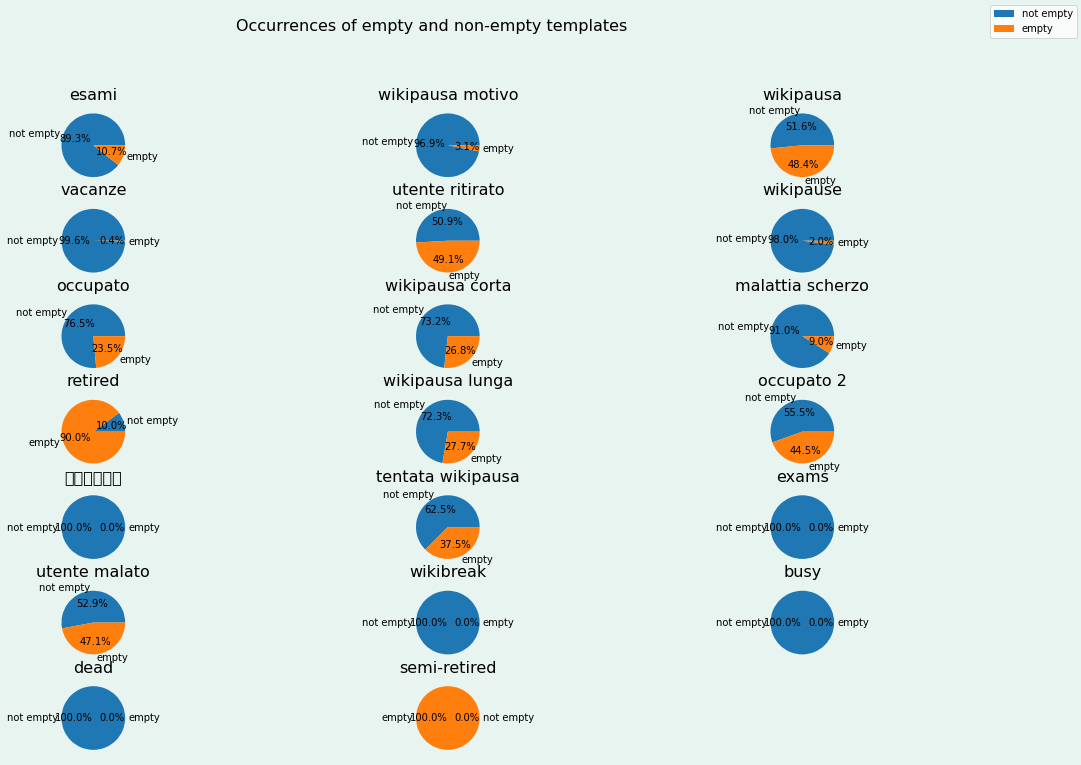

In [291]:
fig, axes = plt.subplots(math.ceil(len(wikibreaks)/3), 3, figsize=(18, 12), facecolor='#e8f4f0', squeeze=False)

last_axes = None


for i, wikibreak in enumerate(wikibreaks):
    # grouping
    extracted = wikibreaks_parameters_df_list[i]
    grouped = extracted.loc[extracted['parameters'] == {}, ['wikibreak', 'parameters', 'count']].groupby(['wikibreak']).count().reset_index(drop=True)
    total_empty = grouped['count']
    
    if not total_empty.empty:
        total_empty = total_empty[0]
    else:
        total_empty = 0
    
    # total empty over total
    row_total = {'total': extracted.shape[0] - total_empty, 'label': 'not empty'}
    row_empty = {'total': total_empty, 'label': 'empty'}
    rows = [row_total, row_empty]
    percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
    
    # figure
    ax = axes[i // 3, i % 3]
    ax.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
    ax.set_title(wikibreak, fontsize=16)
    
    last_axes = i % 3
    
    
for i in range((math.ceil(len(wikibreaks)/3) - 1) * 3 + last_axes + 1, math.ceil(len(wikibreaks)/3) * 3):
    fig.delaxes(axes.flatten()[i])

    
fig.suptitle('Occurrences of empty and non-empty templates', fontsize=16)
fig.legend(['not empty', 'empty'])
plt.show()

Total filled over parameterized

In [292]:
total_without_parameters = parameters_explicited.loc[parameters_explicited['parameters'] == {}, ['wikibreak', 'parameters', 'count']]
total_without_parameters.head()

,wikibreak,parameters,count
0,esami,{},1
1,esami,{},1
2,wikipausa motivo,{},1
3,wikipausa,{},1
4,wikipausa,{},1


In [293]:
row_total = {'total': parameters_explicited.shape[0] - total_without_parameters.shape[0], 'label': 'not empty'}
row_empty = {'total': total_without_parameters.shape[0], 'label': 'empty'}
rows = [row_total, row_empty]
percentage_multiple_times = pd.DataFrame(rows).reset_index(drop=True)
percentage_multiple_times.head()

,total,label
0,3623,not empty
1,833,empty


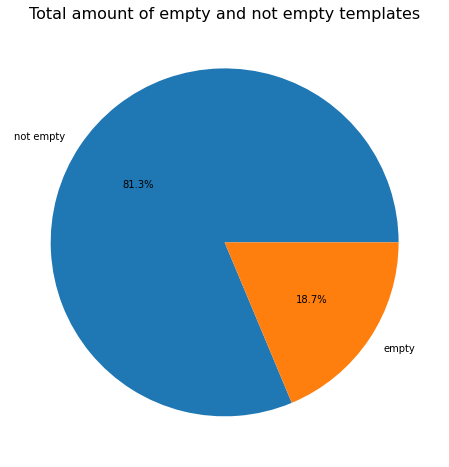

In [294]:
plt.figure(figsize=(16,8))
plt.pie(percentage_multiple_times['total'], labels=percentage_multiple_times['label'], autopct='%.1f%%')
plt.title('Total amount of empty and not empty templates', fontsize=16)
plt.show()

## Most used parameter per template

In [295]:
# dataframes for wikibreaks with param name and value
last_axes = None
most_used_parameters_per_template_df_list = list()

for i, wikibreak in enumerate(wikibreaks):
    # grouping
    extracted = wikibreaks_parameters_df_list[i]
    grouped = extracted.loc[extracted['parameters'] != {}, ['wikibreak', 'parameters', 'count']]
    most_used_parameters_per_template_list = list()
    for i, row in extracted.iterrows():
        for key, value in row['parameters'].items():
            new_row = row
            new_row = new_row.drop('parameters')
            new_row['param_name'] = key
            new_row['param_value'] = value
            most_used_parameters_per_template_list.append(new_row)
    most_used_parameters_per_template_df_list.append(pd.DataFrame(most_used_parameters_per_template_list).reset_index(drop=True))

# most_used_parameters_per_template_df_list[0].head()

In [296]:
most_used_parameters_per_template_df_list[0].shape

(247, 5)

In [297]:
most_used_parameters_per_template_grouped_df_list = list()
for i, wikibreak in enumerate(wikibreaks):
    # grouping
    extracted = most_used_parameters_per_template_df_list[i]
    if not extracted.empty:
        extracted['param_name'] = extracted['param_name'].str.strip()
        extracted = extracted[['count', 'wikibreak', 'param_name']].groupby(['param_name', 'wikibreak']).count().reset_index(drop=False)
    most_used_parameters_per_template_grouped_df_list.append(extracted)
most_used_parameters_per_template_grouped_df_list[0].head()

,param_name,wikibreak,count
0,1,esami,243
1,2,esami,3
2,motivo,esami,1


## Most used parameters per wikibreak

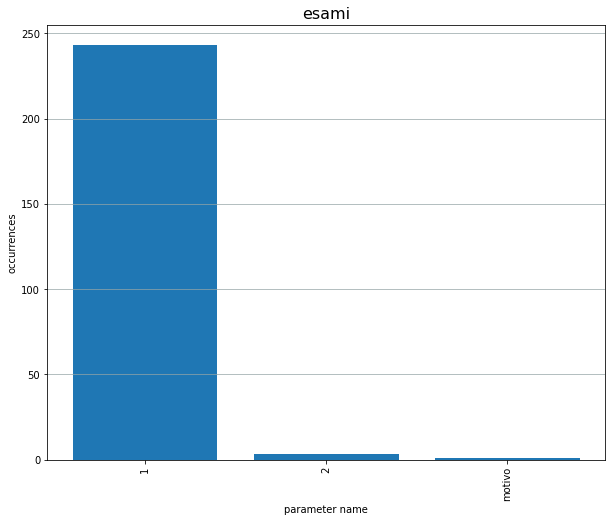

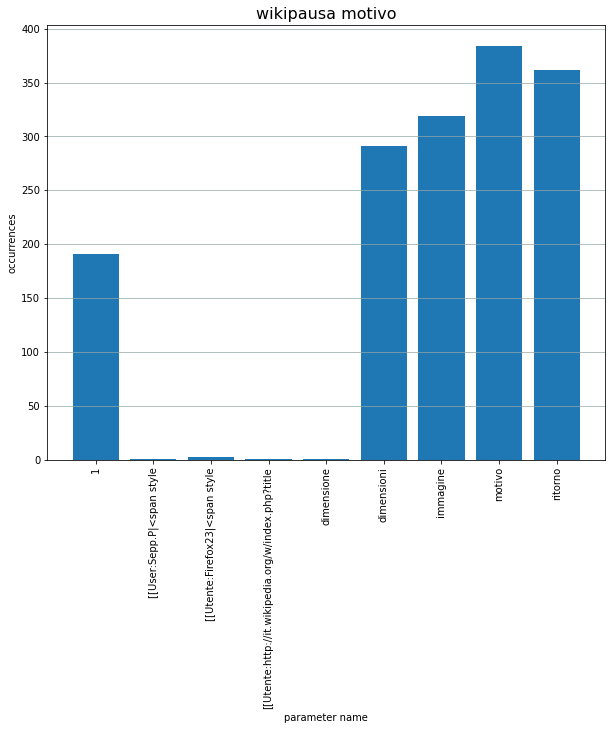

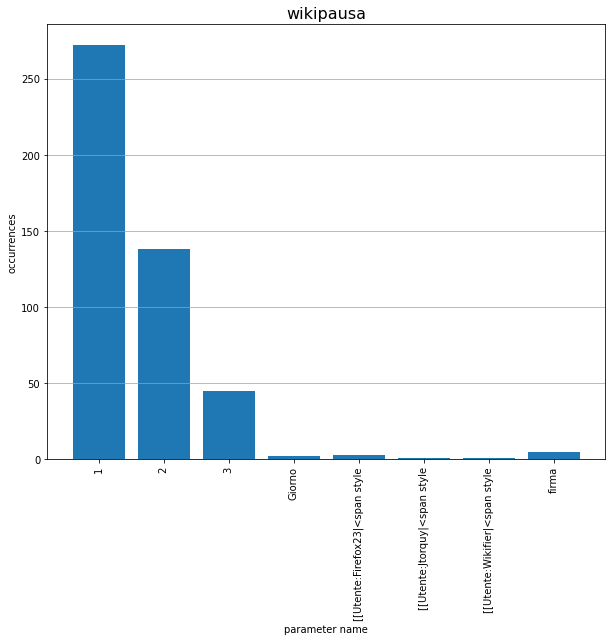

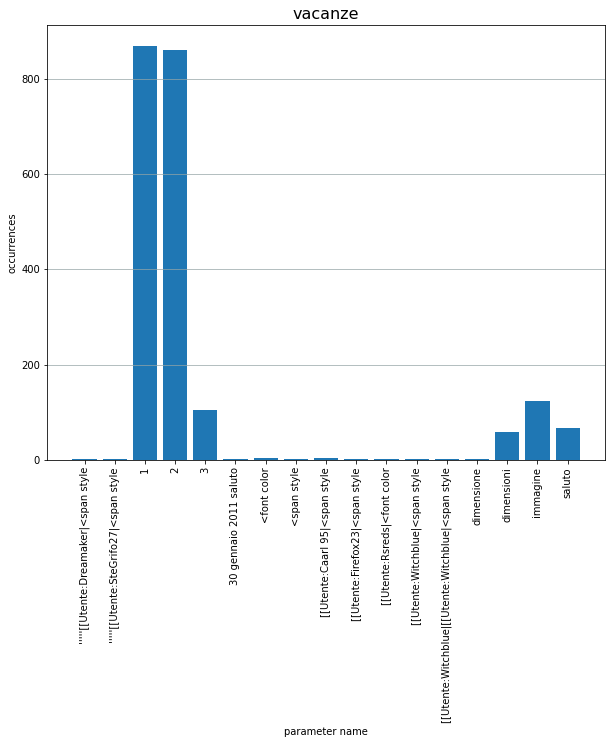

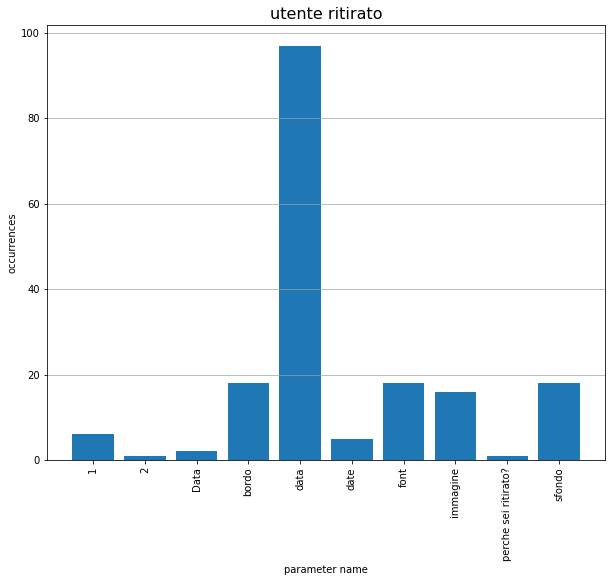

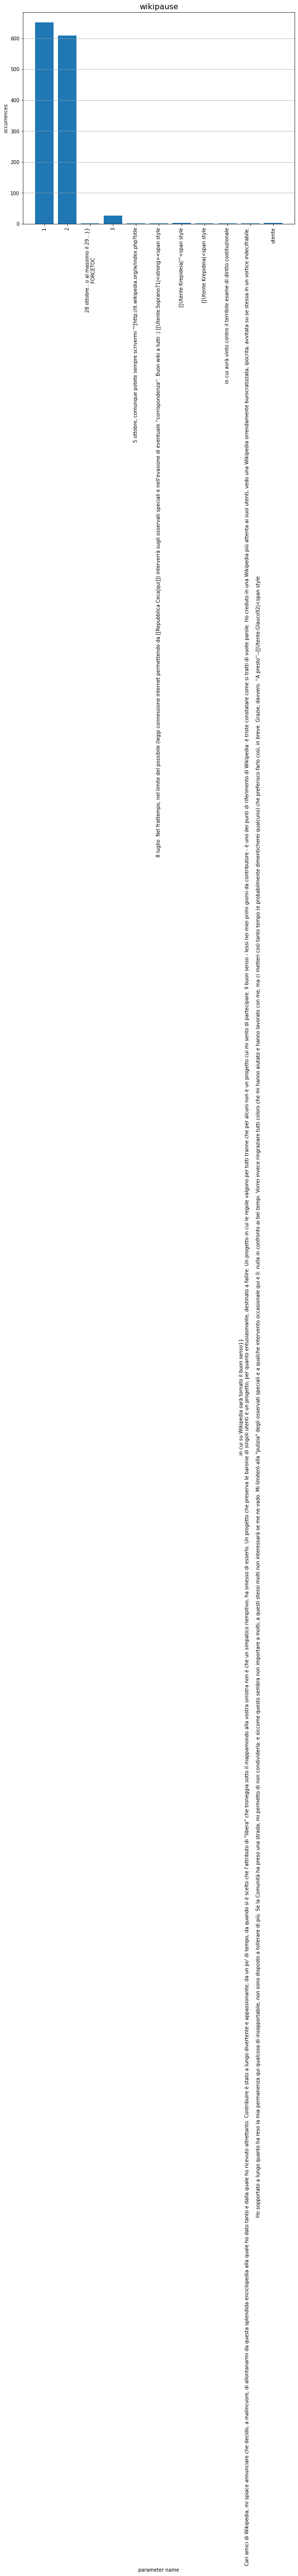

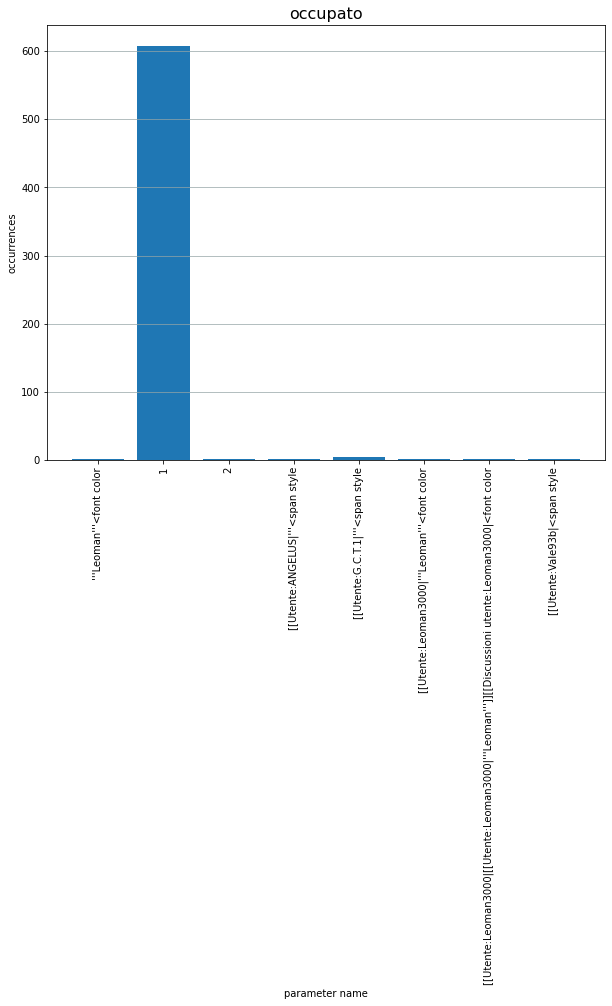

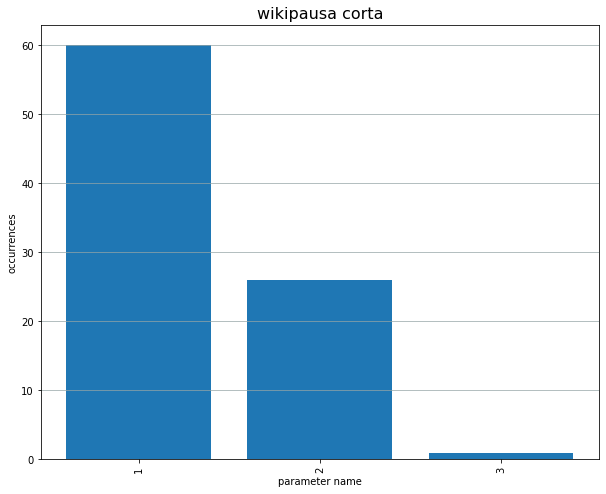

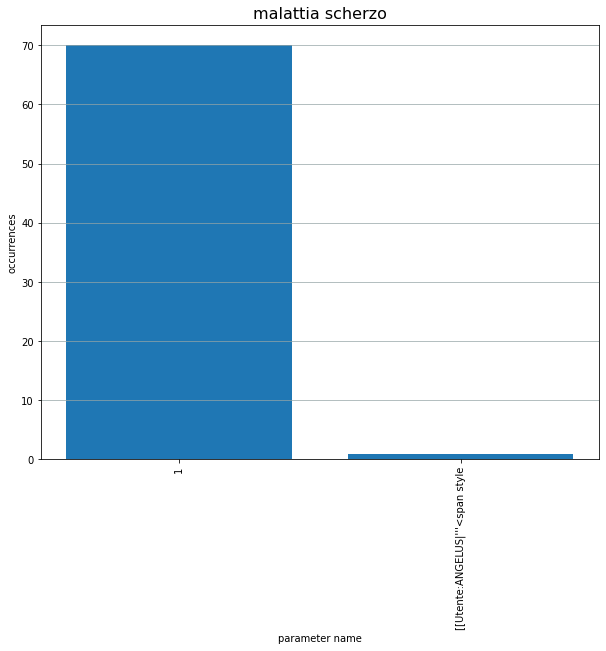

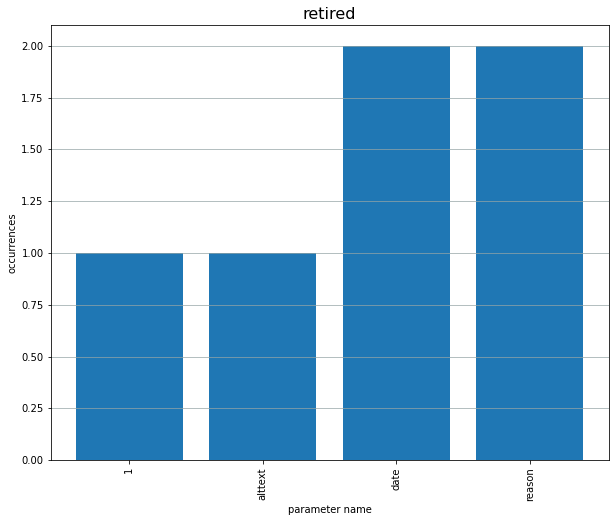

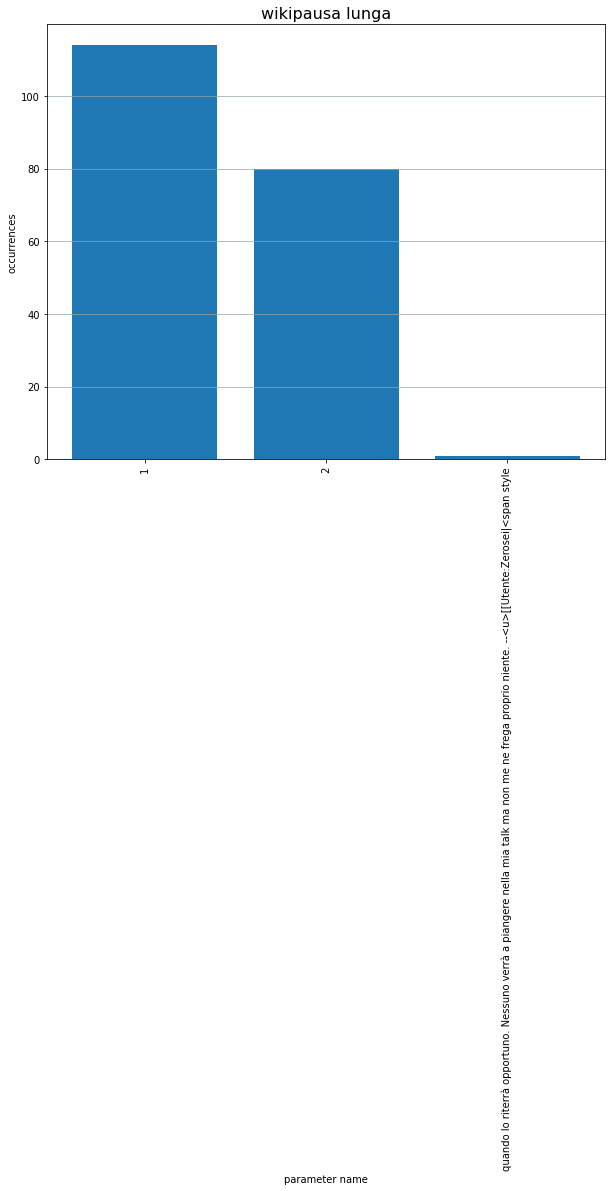

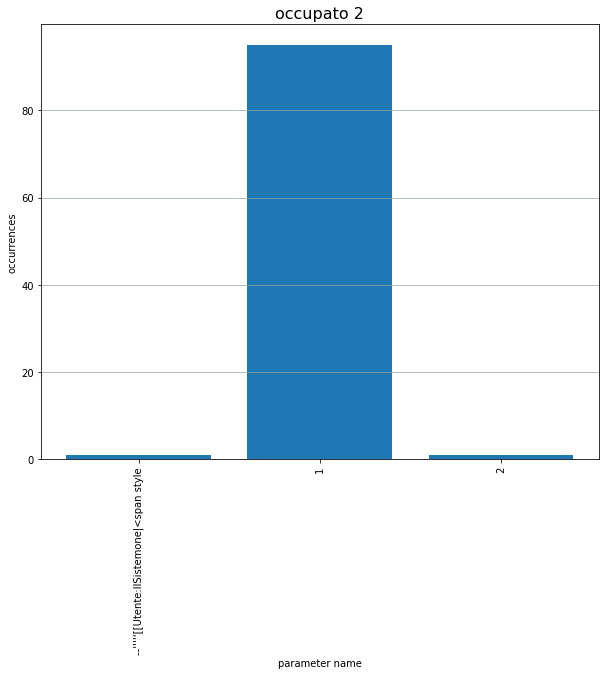

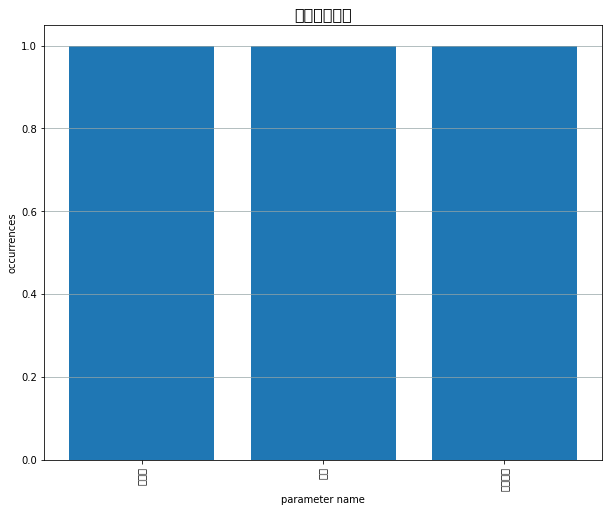

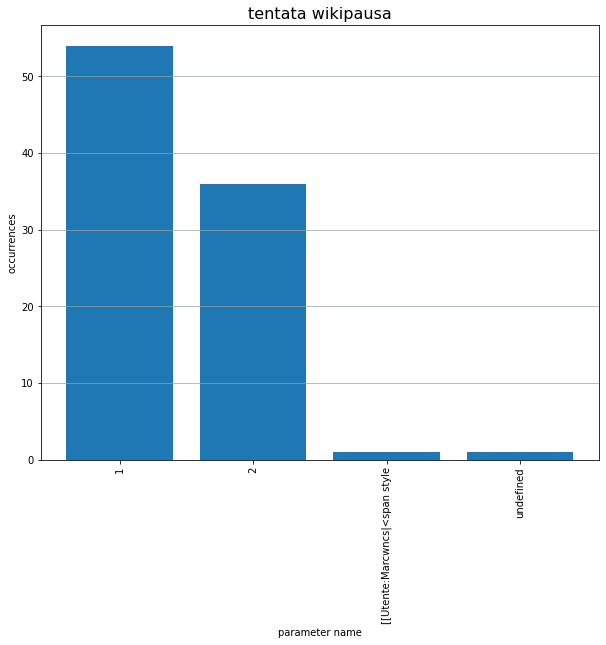

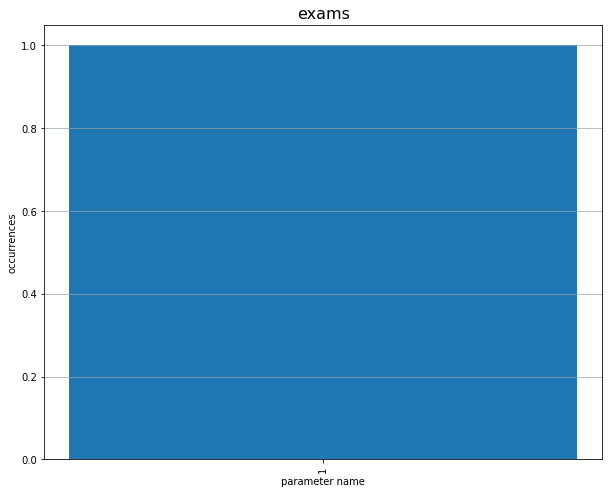

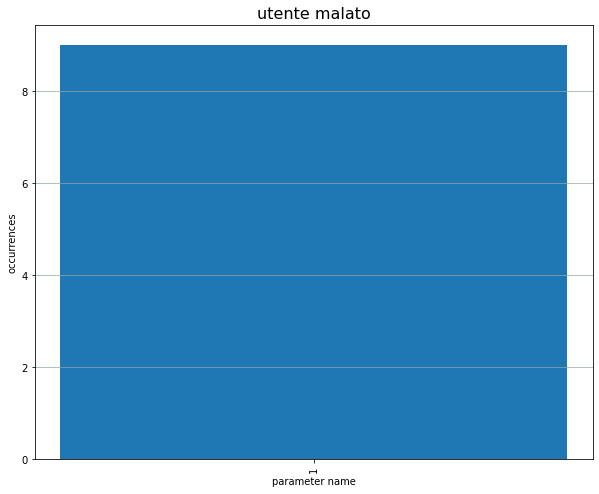

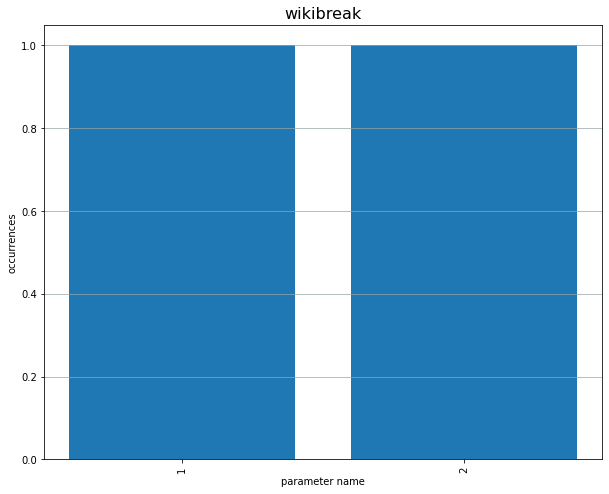

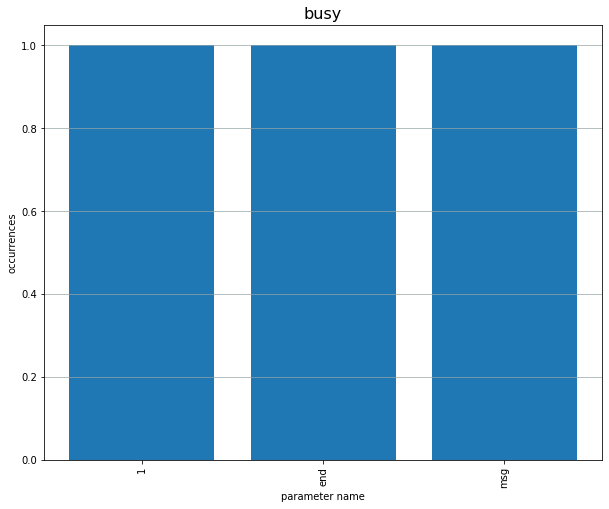

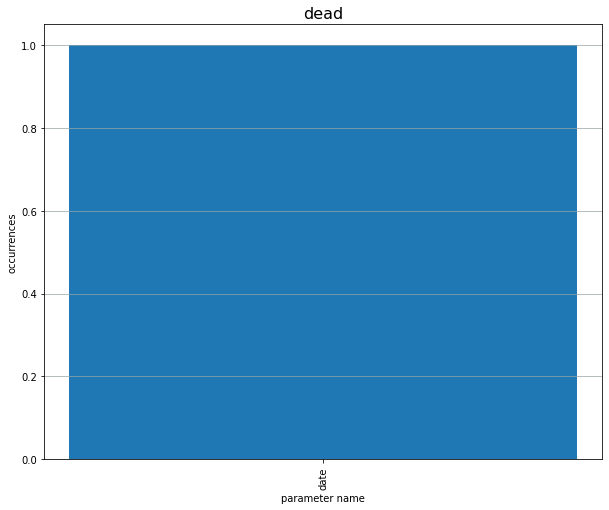

In [298]:
for i, wikibreak in enumerate(wikibreaks):
    # grouping
    extracted = most_used_parameters_per_template_grouped_df_list[i]
    
    if not extracted.empty:
        plt.figure(figsize=(10,8))
        plt.bar(most_used_parameters_per_template_grouped_df_list[i]['param_name'], most_used_parameters_per_template_grouped_df_list[i]['count'])
        plt.title(wikibreak, fontsize=16)
        plt.grid(color='#95a5a6', linestyle='-', linewidth=1, axis='y', alpha=0.7)
        plt.xticks(rotation='vertical')
        plt.ylabel('occurrences')
        plt.xlabel('parameter name')
        plt.show()

## Some paramers in textual form

In [299]:
for i, wikibreak in enumerate(wikibreaks):
    # grouping
    extracted = most_used_parameters_per_template_df_list[i]
    if not extracted.empty:
        print('Template name: ', wikibreak)
        print('------------------------------------------------------------------')
        for i, val in extracted.sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
        print('------------------------------------------------------------------')

Template name:  esami
------------------------------------------------------------------
Param name: 1 param value: Mateusz occurrences: 1
Param name: 1 param value: [[Utente:EffeX2|EffeX2]] occurrences: 1
Param name: 1 param value: [[Utente:EffeX2|EffeX2]] occurrences: 1
Param name: 1 param value: [[Utente:B3t|B3t]] occurrences: 1
Param name: 1 param value: [[Utente:B3t|B3t]] occurrences: 1
Param name: 1 param value: [[Utente:Annalety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:Annalety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:Annalety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:Annalety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:Annalety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:AnnaLety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:AnnaLety|AnnaLety]] occurrences: 1
Param name: 1 param value: [[Utente:Gambo7|Gambo7]] occurrences: 1
Param name: 1 param value: DoppioM occurr

Param name: 1 param value: [[Utente:Tux|Tux]] occurrences: 1
Param name: 1 param value: [[Utente:Tux|Tux]] occurrences: 1
Param name: 1 param value: [[Utente:Sailko|Sailko]] occurrences: 1
Param name: 1 param value: [[Utente:Sailko|Sailko]] occurrences: 1
Param name: 1 param value: [[Utente:Sailko|Sailko]] occurrences: 1
Param name: 1 param value: [[Utente:Cesco0|Cesco]] occurrences: 1
Param name: 1 param value: [[Utente:Frieda|Frieda]] occurrences: 1
Param name: 1 param value: [[Utente:Italo Stefano Moro|Italo Stefano Moro]] occurrences: 1
Param name: 1 param value: [[Utente:Dottormospa|Dottormospa]] occurrences: 1
Param name: 1 param value: [[Utente:Vale maio|Vale maio]] occurrences: 1
Param name: 1 param value: [[Utente:Vale maio|Vale maio]] occurrences: 1
Param name: 1 param value: [[Utente:n0n4m3|n0n4m3]] occurrences: 1
Param name: 1 param value: [[Utente:Radagast92|Radagast92]] occurrences: 1
Param name: 1 param value: [[Utente:Radagast92|Radagast92]] occurrences: 1
Param name: 1

Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value: 20px occurrences: 1
Param name: dimensioni param value: 20px occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value: 20px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value: 150px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  90x90px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni para

Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value: 150px occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  80x80px occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name: dimensioni param value:  occurrences: 1
Param name:

Param name: immagine param value:  Vacanze hawaiane.png occurrences: 1
Param name: immagine param value:  Nuvola apps bookcase.svg
 occurrences: 1
Param name: immagine param value:  Nuvola apps bookcase.svg
 occurrences: 1
Param name: immagine param value:  occurrences: 1
Param name: immagine param value: Emojione 1F4DA.svg occurrences: 1
Param name: immagine param value: Emojione 1F4DA.svg occurrences: 1
Param name: immagine param value:  occurrences: 1
Param name: immagine param value:  Building Site Silhouette.svg
 occurrences: 1
Param name: immagine param value:  occurrences: 1
Param name: immagine param value: Emojione 1F4DA.svg occurrences: 1
Param name: immagine param value: Lightning storm over ocean at night.jpg occurrences: 1
Param name: immagine param value: Spotthecow.gif occurrences: 1
Param name: immagine param value: Spotthecow.gif occurrences: 1
Param name: immagine param value: Topspun.jpg occurrences: 1
Param name: immagine param value: Topspun.jpg occurrences: 1
Para

Param name: immagine param value: Q40953 noun 458092 ccCristianoZoucas prayer.svg occurrences: 1
Param name: immagine param value: Q40953 noun 458092 ccCristianoZoucas prayer.svg occurrences: 1
Param name: immagine param value: Q40953 noun 458092 ccCristianoZoucas prayer.svg occurrences: 1
Param name: immagine param value: Q40953 noun 458092 ccCristianoZoucas prayer.svg occurrences: 1
Param name: immagine param value: Q40953 noun 458092 ccCristianoZoucas prayer.svg occurrences: 1
Param name: immagine param value: Prayer icon.svg occurrences: 1
Param name: immagine param value:  Trekking in montagna.svg
 occurrences: 1
Param name: immagine param value: Wien 3 Wappen.svg occurrences: 1
Param name: immagine param value:  600px Rosso con grifone Bianco scudato e fiamme.png
 occurrences: 1
Param name: immagine param value: Alma Chamber Orchestra salle Pleyel.jpg occurrences: 1
Param name: immagine param value:  Alma Chamber Orchestra salle Pleyel.jpg
 occurrences: 1
Param name: immagine par

Param name: motivo param value:  per necessità di lontananza dal mondo di Internet occurrences: 1
Param name: motivo param value:  per necessità di lontananza dal mondo di Internet occurrences: 1
Param name: motivo param value:  causa esami
 occurrences: 1
Param name: motivo param value:  causa esami
 occurrences: 1
Param name: motivo param value:  motivi che per pigrizia non intende divulgare alla comunità
 occurrences: 1
Param name: motivo param value:  motivi che per pigrizia non intende divulgare alla comunità
 occurrences: 1
Param name: motivo param value: poichè è impegnato a progettare un reattore nucleare (che ci crediate o no...) occurrences: 1
Param name: motivo param value: perchè dovrebbe studiare occurrences: 1
Param name: motivo param value: perchè dovrebbe studiare occurrences: 1
Param name: motivo param value: dalla [[Wikipedia in italiano]] perché preferisce dedicare i propri sforzi alla [[Wikipedia in inglese]] occurrences: 1
Param name: motivo param value:  per impeg

Param name: motivo param value:  causa trasloco
 occurrences: 1
Param name: motivo param value:  per sovraccarico di impegni lavorativi, casalinghi e sociali
 occurrences: 1
Param name: motivo param value:  per una salutare vacanza in montagna
 occurrences: 1
Param name: motivo param value:  per varie questioni di real life che richiedono mente sveglia e possibilmente lontana dalle questioni wikipediane
 occurrences: 1
Param name: motivo param value:  per una salutare vacanza in montagna
 occurrences: 1
Param name: motivo param value:  per varie questioni di real life che richiedono mente sveglia e possibilmente lontana dalle questioni wikipediane
 occurrences: 1
Param name: motivo param value: per non meritate vacanze occurrences: 1
Param name: motivo param value: perché ha lasciato l'Italia per trasferirsi all'estero; non sa quindi, visti i nuovi impegni, se e quando potrà tornare a contribuire regolarmente a Wikipedia occurrences: 1
Param name: motivo param value: perché ha lasciato

Param name: ritorno param value: quando riuscirà a smettere di avere a che fare con questa pericolosa sostanza stupefacente - ci potrebbero volere anni. In compenso, contribuisce saltuariamente e volentieri alla sfera wikipediana attinente a tale disciplina occurrences: 1
Param name: ritorno param value: entro settembre occurrences: 1
Param name: ritorno param value: entro settembre occurrences: 1
Param name: ritorno param value: tra qualche tempo occurrences: 1
Param name: ritorno param value: a fine agosto occurrences: 1
Param name: ritorno param value: nel prossimo weekend occurrences: 1
Param name: ritorno param value: nel prossimo weekend occurrences: 1
Param name: ritorno param value: a marzo occurrences: 1
Param name: ritorno param value: a fine dicembre occurrences: 1
Param name: ritorno param value: non sa ancora quando, ma spera con una vista migliore occurrences: 1
Param name: ritorno param value: quando riuscirà a smettere di avere a che fare con questa pericolosa sostanza 

 occurrences: 1
Param name: ritorno param value:  , forse
 occurrences: 1
Param name: ritorno param value:  , forse
 occurrences: 1
Param name: ritorno param value:  , forse
 occurrences: 1
Param name: ritorno param value:  , forse
 occurrences: 1
Param name: ritorno param value: quando avrà del tempo libero (principalmente di domenica), cercando comunque di fare [[Aiuto:Modifica minore|qualcosa]] e di prendere parte a [[Wp:DISCUSSIONE|discussioni]] occurrences: 1
Param name: ritorno param value: se e quando sarà il momento occurrences: 1
Param name: ritorno param value: se e quando sarà il momento occurrences: 1
Param name: ritorno param value: appena sarà guarito occurrences: 1
Param name: ritorno param value: appena sarà guarito occurrences: 1
Param name: ritorno param value: quando saranno finite le [[patate]] occurrences: 1
Param name: ritorno param value: quando saranno finite le [[patate]] occurrences: 1
Param name: ritorno param value: quando qualcosa gli avrà rallietato la vit

Param name: 1 param value: Gita non meritata occurrences: 1
Param name: 1 param value: Stupeficium pigro occurrences: 1
Param name: 1 param value: 29 novembre, causa impegni IRL occurrences: 1
Param name: 1 param value: Barbaking occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] occurrences: 1
Param name: 1 param value: [[Utente:Cristiano64|Cristiano64]] 

Param name: 1 param value: [[Utente:AlfredoPuca|AlfredoPuca]] occurrences: 1
Param name: 1 param value: [[Utente:AlfredoPuca|AlfredoPuca]] occurrences: 1
Param name: 1 param value: [[Utente:Luca M|Luca M]] occurrences: 1
Param name: 1 param value: [[Utente:DerfelDiCadarn87|Il buon caro Derfel]] occurrences: 1
Param name: 1 param value: } occurrences: 1
Param name: 1 param value: [[Utente:Sepp.P|Sepp]] occurrences: 1
Param name: 1 param value: Sepp occurrences: 1
Param name: 1 param value: Sepp occurrences: 1
Param name: 1 param value: [[Utente:Tarasov|Tarasov]] occurrences: 1
Param name: 1 param value: Giobru occurrences: 1
Param name: 1 param value: [[Utente:Giobru|GioBru]] occurrences: 1
Param name: 1 param value: --[[Utente:Bombtails|Bombtails]] ([[Discussioni utente:Bombtails|msg]]) 16:12, 3 lug 2012 (CEST) occurrences: 1
Param name: 1 param value: --[[Utente:Bombtails|Bombtails]] ([[Discussioni utente:Bombtails|msg]]) 16:12, 3 lug 2012 (CEST) occurrences: 1
Param name: 1 param val

Param name: 3 param value: , giusto il tempo di staccare un po' la spina occurrences: 1
Param name: 3 param value: , giusto il tempo di staccare un po' la spina occurrences: 1
Param name: 3 param value: , anche se sicuramente non riuscirà a non tornarvici prima occurrences: 1
Param name: 3 param value: , anche se sicuramente non riuscirà a non tornarvici prima occurrences: 1
Param name: 3 param value: , quando lo riterrà giusto occurrences: 1
Param name: 3 param value: , quando lo riterrà giusto occurrences: 1
Param name: 3 param value: , anche se sicuramente non riuscirà a non tornarvici prima occurrences: 1
Param name: 3 param value: , anche se sicuramente non riuscirà a non tornarvici prima occurrences: 1
Param name: 3 param value: , causa oratorio occurrences: 1
Param name: 3 param value: . Durante questo periodo l'attività wikipediana sarà ridotta al minimo e i messaggi verranno letti di rado occurrences: 1
Param name: 3 param value: , giusto il tempo per godersi la vita xD occurr

Param name: 1 param value: AttoRenato occurrences: 1
Param name: 1 param value: AttoRenato occurrences: 1
Param name: 1 param value: AttoRenato occurrences: 1
Param name: 1 param value: AttoRenato occurrences: 1
Param name: 1 param value: AttoRenato occurrences: 1
Param name: 1 param value: Francesco occurrences: 1
Param name: 1 param value: FiloSottile occurrences: 1
Param name: 1 param value: FiloSottile occurrences: 1
Param name: 1 param value: FiloSottile occurrences: 1
Param name: 1 param value: FiloSottile occurrences: 1
Param name: 1 param value: [[Utente:FiloSottile|FiloSottile]] occurrences: 1
Param name: 1 param value: Tia solzago occurrences: 1
Param name: 1 param value: [[Utente:Filippo2192|Filippo2192]] occurrences: 1
Param name: 1 param value: Filippo2192 occurrences: 1
Param name: 1 param value: [[Utente:Filippo2192|Filippo2192]] occurrences: 1
Param name: 1 param value: [[Utente:Filippo2192|Filippo2192]] occurrences: 1
Param name: 1 param value: [[Utente:Leoman3000|Leom

Param name: 1 param value: [[Utente:Powering|Powering]] occurrences: 1
Param name: 1 param value: [[Utente:Lepido|Lepido]]
 occurrences: 1
Param name: 1 param value: [[Utente:Nicoli|Nico48]] occurrences: 1
Param name: 1 param value: [[Utente:Nicoli|Nico48]] occurrences: 1
Param name: 1 param value: [[Utente:Ripepette|Ripe]] occurrences: 1
Param name: 1 param value: [[Utente:Ripepette|Ripe]] occurrences: 1
Param name: 1 param value: [[Utente:Ripepette|Ripe]] occurrences: 1
Param name: 1 param value: [[Utente:Ripepette|Ripe]] occurrences: 1
Param name: 1 param value: [[Utente:Sally888|Sally888]] occurrences: 1
Param name: 1 param value: [[Utente:MarkyRamone92|MarkyRamone92]]
 occurrences: 1
Param name: 1 param value: [[Utente:Demart81|Demart81]] occurrences: 1
Param name: 1 param value: [[Utente:Ferdi2005|Ferdi2005]] occurrences: 1
Param name: 1 param value: [[Utente:Ferdi2005|ferdi2005]]
 occurrences: 1
Param name: 1 param value: [[Utente:Midnight bird|Midnight bird]] occurrences: 1
Par

Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value

Param name: 1 param value: Triple 8 occurrences: 1
Param name: 1 param value: [[Utente:Triple 8|Triple 8]] occurrences: 1
Param name: 1 param value: il Triple
 occurrences: 1
Param name: 1 param value: il Triple   
 occurrences: 1
Param name: 1 param value: [[Utente:Dwalin|Dwalin]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dwalin|Dwalin]]
 occurrences: 1
Param name: 1 param value: [[Utente:Antonov|Antonov]] occurrences: 1
Param name: 1 param value: [[Utente:Antonov|Antonov]]5 occurrences: 1
Param name: 1 param value: [[Utente:Antonov|Antonov]] occurrences: 1
Param name: 1 param value: [[Utente:Antonov|Antonov]] occurrences: 1
Param name: 1 param value: [[Utente:Twilight|Twilight]] occurrences: 1
Param name: 1 param value: [[Utente:Nick1915|Nick1915]] occurrences: 1
Param name: 1 param value: [[Utente:Alex92|Il proprietario della pagina]] occurrences: 1
Param name: 1 param value: [[Utente:Girolamo88|Il proprietario della pagina]] occurrences: 1
Param name: 1 param value: [[Ute

Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param value: [[Utente:Dave93b|Dave93b]]
 occurrences: 1
Param name: 1 param 

Param name: 2 param value: 15, scendendo lentamente dall'Adriatico buono.
 occurrences: 1
Param name: 2 param value: 28 dicembre 2007 (ma forse ci sarò per rispondere ai pochi messaggi che ricevo) occurrences: 1
Param name: 2 param value: 28 dicembre 2007 (ma forse ci sarò per rispondere ai pochi messaggi che ricevo) occurrences: 1
Param name: 2 param value: dal 13 al 18 occurrences: 1
Param name: 2 param value: 18 gennaio 2008. occurrences: 1
Param name: 2 param value: 17 agosto occurrences: 1
Param name: 2 param value: 31 marzo occurrences: 1
Param name: 2 param value: 10 agosto
 occurrences: 1
Param name: 2 param value: [[2 agosto]] [[2007]] occurrences: 1
Param name: 2 param value: 19 agosto 2007 occurrences: 1
Param name: 2 param value: '''25 marzo 2008''' occurrences: 1
Param name: 2 param value: '''28 aprlie 2008''' occurrences: 1
Param name: 2 param value: 28 agosto occurrences: 1
Param name: 2 param value: 9 settembre occurrences: 1
Param name: 2 param value: 12 agosto occurre

Param name: 2 param value:  giovedì 18 luglio occurrences: 1
Param name: 2 param value: circa il 20 agosto occurrences: 1
Param name: 2 param value: 26 agosto
 occurrences: 1
Param name: 2 param value: Quando finirò i giga occurrences: 1
Param name: 2 param value: quando l'inferno si gela occurrences: 1
Param name: 2 param value: 31 agosto 2009 occurrences: 1
Param name: 2 param value: tra circa due-tre settimane
 occurrences: 1
Param name: 2 param value: tra circa due-tre giorni
 occurrences: 1
Param name: 2 param value: 29 luglio 2011. occurrences: 1
Param name: 2 param value: 30 luglio 2011. occurrences: 1
Param name: 2 param value: 14 p.v. occurrences: 1
Param name: 2 param value: 14 p.v. occurrences: 1
Param name: 2 param value: 1 settembre occurrences: 1
Param name: 2 param value: in cui tornerà la voglia di divertirsi, evitando le discussioni "impossibili" dei "soliti noti" occurrences: 1
Param name: 2 param value: in cui avrà ancora voglia di divertirsi, evitando le discussioni

Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  in cui sarà sicura di avere fatto abbastanza vacanze (presumibilmente l' 1 agosto). Ma può darsi che riesca a scroccare un computer anche via da casa perché sa già che Wikipedia è molto più rilassante di qualsiasi vacanza.. occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  in cui sarà sicura di avere fatto abbastanza vacanze (presumibilmente l' 1 agosto). Ma può darsi che riesca a scroccare un computer anche via da casa perché sa già che Wikipedia è molto più rilassante di qualsiasi vacanza.. occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  in cui sarà sicura di avere fatto abbastanza vacanze (presumibilmente l' 1 agosto). Ma può darsi che riesca a scroccare un computer anche via da casa perché sa già che Wikipedia è 

Param name: 2 param value: 30 gennaio 2011  occurrences: 1
Param name: 2 param value: 30 dicembre 2011  occurrences: 1
Param name: 2 param value: ... beh! Diciamo la prossima settimana... forse... occurrences: 1
Param name: 2 param value: in cui finirà le vacanze (ovvio, no?). occurrences: 1
Param name: 2 param value: 19 giugno occurrences: 1
Param name: 2 param value: 19 giugno occurrences: 1
Param name: 2 param value: 10 agosto occurrences: 1
Param name: 2 param value: 5 ottobre occurrences: 1
Param name: 2 param value: ignoto occurrences: 1
Param name: 2 param value: il 31 Luglio occurrences: 1
Param name: 2 param value: 26 agosto
 occurrences: 1
Param name: 2 param value: verso il 10 giugno occurrences: 1
Param name: 2 param value: verso il 10 giugno occurrences: 1
Param name: 2 param value: 22 agosto 2008 occurrences: 1
Param name: 2 param value: dell'uscita di ''Ritorno al futuro parte IV'' occurrences: 1
Param name: 2 param value: … occurrences: 1
Param name: 2 param value: il 1

Param name: 2 param value:  il [[4 novembre]]
 occurrences: 1
Param name: 2 param value:  al prossimo controesodo
 occurrences: 1
Param name: 2 param value:  il [[4 novembre]]
 occurrences: 1
Param name: 2 param value:  al prossimo controesodo
 occurrences: 1
Param name: 2 param value:  il [[4 novembre]]
 occurrences: 1
Param name: 2 param value:  al prossimo controesodo
 occurrences: 1
Param name: 2 param value:  il [[4 novembre]]
 occurrences: 1
Param name: 2 param value:  al prossimo controesodo
 occurrences: 1
Param name: 2 param value:  il [[4 novembre]]
 occurrences: 1
Param name: 2 param value:  al prossimo controesodo
 occurrences: 1
Param name: 2 param value:  il [[4 novembre]]
 occurrences: 1
Param name: 2 param value:  al prossimo controesodo
 occurrences: 1
Param name: 2 param value:  il [[4 novembre]]
 occurrences: 1
Param name: 2 param value:  al prossimo controesodo
 occurrences: 1
Param name: 2 param value:  il [[4 novembre]]
 occurrences: 1
Param name: 2 param value:  

Param name: dimensioni param value:  100 px occurrences: 1
Param name: dimensioni param value:  50px occurrences: 1
Param name: dimensioni param value: 100px occurrences: 1
Param name: dimensioni param value:  Per impostare dimensioni dell'immagine diverse da quelle standard (facoltativo)
}} occurrences: 1
Param name: dimensioni param value:  75px occurrences: 1
Param name: dimensioni param value:  75px occurrences: 1
Param name: dimensioni param value:  70px occurrences: 1
Param name: dimensioni param value:  65px occurrences: 1
Param name: dimensioni param value:  65px occurrences: 1
Param name: dimensioni param value:  65px occurrences: 1
Param name: dimensioni param value:  65px occurrences: 1
Param name: dimensioni param value:  Per impostare dimensioni dell'immagine diverse da quelle standard (facoltativo) occurrences: 1
Param name: dimensioni param value:  75px occurrences: 1
Param name: dimensioni param value:  75px occurrences: 1
Param name: dimensioni param value:  75px occur

Param name: saluto param value:  [[Bender (Futurama)|Addio insaccati :-)!]] occurrences: 1
Param name: saluto param value:  [[Homer Simpson|Mitico!!!]] occurrences: 1
Param name: saluto param value: [[Philip J. Fry|Che fissa!]] occurrences: 1
Param name: saluto param value: Bella gente, se vedemmu! occurrences: 1
Param name: saluto param value:  Ciaociao!! occurrences: 1
Param name: saluto param value:  Ciaociao!! occurrences: 1
Param name: saluto param value:  Ciaociao!! occurrences: 1
Param name: saluto param value: Hasta la vista! occurrences: 1
Param name: saluto param value: A presto! occurrences: 1
Param name: saluto param value:  Aloha! occurrences: 1
Param name: saluto param value:  Aloha! occurrences: 1
Param name: saluto param value:  occurrences: 1
Param name: saluto param value: A presto! occurrences: 1
Param name: saluto param value:  Ciao ciao! occurrences: 1
Param name: saluto param value: Saluti dalla [[Croazia]]! occurrences: 1
Param name: saluto param value: Non potrà

Param name: data param value: da adesso!!! occurrences: 1
Param name: data param value: da adesso!!! occurrences: 1
Param name: data param value: da adesso!!! occurrences: 1
Param name: data param value: da adesso!!! occurrences: 1
Param name: data param value: dal 08/07/2014 occurrences: 1
Param name: data param value: dal 19 settembre 2014 occurrences: 1
Param name: data param value: dal 28 dicembre 2018. occurrences: 1
Param name: data param value: dal 28 dicembre 2018. occurrences: 1
Param name: data param value: dal 28 dicembre 2018. occurrences: 1
Param name: data param value: dal 28 dicembre 2018. occurrences: 1
Param name: data param value: 29 maggio 2007 occurrences: 1
Param name: data param value: dal 29 maggio 2007 occurrences: 1
Param name: data param value: dall'8 agosto 2015. occurrences: 1
Param name: data param value: dall'8 agosto 2015. occurrences: 1
Param name: data param value:  dal 2 novembre 2014. <small>L'utenza rimarrà comunque sempre aperta in caso l'utente vog

Param name: 1 param value: Carlo Morino, detto anche zi<noinclude>'</noinclude> Carlo,'' occurrences: 1
Param name: 1 param value: Carlo Morino, detto anche zi<noinclude>'</noinclude> Carlo,'' occurrences: 1
Param name: 1 param value: Carlo Morino, detto anche zi<noinclude>'</noinclude> Carlo,'' occurrences: 1
Param name: 1 param value: Carlo Morino, detto anche zi<noinclude>'</noinclude> Carlo,'' occurrences: 1
Param name: 1 param value: Carlo Morino, detto anche zi<noinclude>'</noinclude> Carlo,'' occurrences: 1
Param name: 1 param value: Carlo Morino, detto anche zi<noinclude>'</noinclude> Carlo,'' occurrences: 1
Param name: 1 param value: Carlo Morino, detto anche zi<noinclude>'</noinclude> Carlo,'' occurrences: 1
Param name: 1 param value: Carlo Morino, detto anche zi<noinclude>'</noinclude> Carlo,'' occurrences: 1
Param name: 1 param value: Carlo Morino, detto anche zi<noinclude>'</noinclude> Carlo, occurrences: 1
Param name: 1 param value: Carlo Morino, detto anche zi<noinclude>

Param name: 1 param value: [[Utente:RoccoAffinito|Roccoaffinito]] occurrences: 1
Param name: 1 param value: [[Utente:Roccoaffinito|RoccoAffinito]] occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: Alexander VIII occurrences: 1
Param name: 1 param value: [[Utente:Bramfab|Bramfab]]  occurrences: 1
Param name: 1 param value: [[Utente:Bramfab|Bramfab]] occurrences: 1
Param name: 1 param value: [[Utente:The Crawler|The Crawler]] occurrence

Param name: 1 param value: Lo zio Carlo occurrences: 1
Param name: 1 param value: il vostro amato zietto occurrences: 1
Param name: 1 param value: il vostro amato zietto occurrences: 1
Param name: 1 param value: [[Utente:Jacopolinux|Jacopolinux]] occurrences: 1
Param name: 1 param value: [[Utente:Jacopolinux|Jacopolinux]] occurrences: 1
Param name: 1 param value: [[Utente:Zweig92|Zweig92]] occurrences: 1
Param name: 1 param value: Suetonius occurrences: 1
Param name: 1 param value: in cui avrà risolto alcuni problemi nella sua vita reale occurrences: 1
Param name: 1 param value: in cui si sarà definitivamente liberato dei suoi numerosi impegni occurrences: 1
Param name: 1 param value: [[Utente:Màrço 27|Màrço 27]] occurrences: 1
Param name: 1 param value: [[Utente:Zuuma]] occurrences: 1
Param name: 1 param value: [[Zuuma]] occurrences: 1
Param name: 1 param value: [[utente:Zuuma]] occurrences: 1
Param name: 1 param value: [[Utente:Zuuma]] occurrences: 1
Param name: 1 param value: [[Uten

Param name: 1 param value: [[Utente:Payu|Payu]] occurrences: 1
Param name: 1 param value: [[Utente:Payu|Payu]] occurrences: 1
Param name: 1 param value: [[Utente:Castagna|CastaÑa]] occurrences: 1
Param name: 1 param value: dzag occurrences: 1
Param name: 1 param value: Jaakko occurrences: 1
Param name: 1 param value: 11 ottobre occurrences: 1
Param name: 1 param value: Umberto occurrences: 1
Param name: 1 param value: Presbite occurrences: 1
Param name: 1 param value: Presbite occurrences: 1
Param name: 1 param value: Presbite occurrences: 1
Param name: 1 param value: Presbite occurrences: 1
Param name: 1 param value: Presbite occurrences: 1
Param name: 1 param value: [[Utente:Klaudio|Klaudio]] occurrences: 1
Param name: 1 param value: Xander occurrences: 1
Param name: 1 param value: [[Utente:Canestro|Canestro]] occurrences: 1
Param name: 1 param value: [[Utente:Lorenzo Taddei|Lorenzo Taddei]] occurrences: 1
Param name: 1 param value: [[Utente:Lorenzo Taddei]] occurrences: 1
Param name

Param name: 2 param value: lunedì 18 giugno (si spera) occurrences: 1
Param name: 2 param value: lunedì 18 giugno (si spera) occurrences: 1
Param name: 2 param value: 1 o 2 luglio, sempre salvo imprevisti occurrences: 1
Param name: 2 param value: 1 o 2 luglio, sempre salvo imprevisti occurrences: 1
Param name: 2 param value: 30 luglio (?) occurrences: 1
Param name: 2 param value: 30 luglio (se Dio vorrà) occurrences: 1
Param name: 2 param value: "???" di settembre (se Dio vorrà) occurrences: 1
Param name: 2 param value: 30 luglio (se Dio vorrà) occurrences: 1
Param name: 2 param value: "???" di settembre (se Dio vorrà) occurrences: 1
Param name: 2 param value: 27 o 28 aprile occurrences: 1
Param name: 2 param value: 27 (o 28) aprile occurrences: 1
Param name: 2 param value: 27 aprile occurrences: 1
Param name: 2 param value: 27 (o 28) aprile occurrences: 1
Param name: 2 param value: 4 (o 5) maggio occurrences: 1
Param name: 2 param value: 4 (o 5) maggio occurrences: 1
Param name: 2 par

Param name: 2 param value: fine estate occurrences: 1
Param name: 2 param value:  quando gli passerà il nervoso per i soliti attacchi del solito troll bannato infinito occurrences: 1
Param name: 2 param value:  quando gli passerà il nervoso per i soliti attacchi del solito troll bannato infinito occurrences: 1
Param name: 2 param value:   quando gli passerà il nervoso per i soliti attacchi del solito troll bannato infinito occurrences: 1
Param name: 2 param value:  un giorno verso fine mese occurrences: 1
Param name: 2 param value:  4 o 5 Agost occurrences: 1
Param name: 2 param value:  4 o 5 Agost occurrences: 1
Param name: 2 param value:  11 o 12 Agosto occurrences: 1
Param name: 2 param value:  1-2 settembre probabilmente - Buone vacanze anche a te che leggi occurrences: 1
Param name: 2 param value: 6 aprile occurrences: 1
Param name: 2 param value:  Oggi occurrences: 1
Param name: 2 param value: 22 giugno 2010 occurrences: 1
Param name: 2 param value:  non si sa esattamente, occurr

Param name: 2 param value: [[28 dicembre]] [[2007]] occurrences: 1
Param name: 2 param value: [[1 febbraio]] [[2008]] occurrences: 1
Param name: 2 param value: [[17 marzo]], bello fresco e pronto alle '''''Settimane Sudamericane!!!''''' occurrences: 1
Param name: 2 param value: che sarà più stabile (lui, non Wikipedia) occurrences: 1
Param name: 2 param value: '''10 settembre''' (o forse anche no ;P) occurrences: 1
Param name: 2 param value:  che deciderà lui, forse ... occurrences: 1
Param name: 2 param value:  che deciderà lui, forse ... occurrences: 1
Param name: 2 param value:  Ci vediamo dopo le vacanze occurrences: 1
Param name: 2 param value:  18 agosto - a meno di presenze saltuarie e fantasmatiche :-) occurrences: 1
Param name: 2 param value:  in cui completerà il suo trasloco - a meno di presenze saltuarie e fantasmatiche :-) occurrences: 1
Param name: 2 param value:  in cui avrà completato il suo trasloco (sta cambiando casa) - a meno di presenze saltuarie e fantasmatiche :-

Param name: '''Leoman'''<font color param value: "red">''3000''</font> occurrences: 1
Param name: 1 param value: [[Utente:Margherita|Paola]] occurrences: 1
Param name: 1 param value: [[Utente:Margherita|Margherita]] occurrences: 1
Param name: 1 param value: Glauco92 occurrences: 1
Param name: 1 param value: [[Utente:EffeX2|EffeX2]] occurrences: 1
Param name: 1 param value: [[Utente:Frank50s|Frank50s]] occurrences: 1
Param name: 1 param value: [[Frank50s]] occurrences: 1
Param name: 1 param value: [[Utente:Frank50s|Frank50s]] occurrences: 1
Param name: 1 param value: Frank50s occurrences: 1
Param name: 1 param value: Frank50s occurrences: 1
Param name: 1 param value: Questo utente occurrences: 1
Param name: 1 param value: [[Utente:Exorcist90|Exorcist90]] occurrences: 1
Param name: 1 param value: Exorcist90 occurrences: 1
Param name: 1 param value: Exorcist90 occurrences: 1
Param name: 1 param value: Exorcist90 occurrences: 1
Param name: 1 param value: Exorcist90 occurrences: 1
Param nam

Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param name: 1 param value: [[Utente:valepert|valepert]] occurrences: 1
Param 

Param name: 1 param value: [[Utente:Albysprx|Albysprx]] occurrences: 1
Param name: 1 param value: [[Utente:Bonza|Bonza]] occurrences: 1
Param name: 1 param value: [[Utente:Bonza|Bonza]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha]] occurrences: 1
Param name: 1 param value: [[Utente:Katiusha89|Katiusha89]]

Param name: 1 param value: Filippo2192 occurrences: 1
Param name: 1 param value: Filippo2192 occurrences: 1
Param name: 1 param value: [[Utente:DaP|Daniele]] occurrences: 1
Param name: 1 param value: [[Utente:Gim²y|Gim²y]] occurrences: 1
Param name: 1 param value: [[Utente:Taz92|Taz92]] occurrences: 1
Param name: 1 param value: Questo utente occurrences: 1
Param name: 1 param value: lusum occurrences: 1
Param name: 1 param value: lusum occurrences: 1
Param name: 1 param value: [[Utente:Grasso83|Grasso83]] occurrences: 1
Param name: 1 param value: [[Utente:*Enrikhino*|*Enrikhino*]] occurrences: 1
Param name: 1 param value: [[Utente:Enrikhino|Enrikhino]] occurrences: 1
Param name: 1 param value: [[Utente:Kir Kanos|Kir Kanos]] occurrences: 1
Param name: 1 param value: bramfab occurrences: 1
Param name: 1 param value: bramfab occurrences: 1
Param name: 1 param value: bramfab occurrences: 1
Param name: 1 param value: bramfab occurrences: 1
Param name: 1 param value: Gondola occurrences: 1
P

Param name: 2 param value: tra un paio di giorni occurrences: 1
Param name: 2 param value: tra circa un'ora occurrences: 1
Param name: 2 param value: tra entro un'ora e 30 minuti occurrences: 1
Param name: 2 param value: dopo pranzo occurrences: 1
Param name: 2 param value: alla fine della passeggiata occurrences: 1
Param name: 2 param value: fra pochi giorni occurrences: 1
Param name: 2 param value: fra pochi giorni occurrences: 1
Param name: 2 param value: il 7 ottobre occurrences: 1
Param name: 2 param value: appena finiranno le verifiche di fine trimestre occurrences: 1
Param name: 2 param value: tra una settimana occurrences: 1
Param name: 2 param value: tra un paio di giorni, se tutto va bene occurrences: 1
Param name: 2 param value: tra un pò di giorni, se tutto va bene occurrences: 1
Param name: 2 param value: tra qualche giorno occurrences: 1
Param name: 2 param value: un paio di giorni occurrences: 1
Param name: 2 param value: un paio di giorni, anche se qualche edit qua e là

Param name: 1 param value: [[Utente:Erik1991|Erik1991]] occurrences: 1
Param name: 1 param value: [[Utente:Guidomac|Guidomac]] occurrences: 1
Param name: 1 param value: [[Utente:Esempio|Esempio]] occurrences: 1
Param name: 1 param value: [[Questo individuo]] occurrences: 1
Param name: 1 param value: [Questo individuo] occurrences: 1
Param name: 1 param value: Questo individuo occurrences: 1
Param name: 1 param value: [[Utente:Guidomac|Guidomac]] occurrences: 1
Param name: 1 param value: [[Utente:GMatteotti|GMatteotti]] occurrences: 1
Param name: 1 param value: [[Utente:GMatteotti|GMatteotti]] occurrences: 1
Param name: 1 param value: [[Utente:GMatteotti|GMatteotti]] occurrences: 1
Param name: 1 param value: [[Utente:GMatteotti|GMatteotti]] occurrences: 1
Param name: 1 param value: [[Utente:GMatteotti|GMatteotti]] occurrences: 1
Param name: 1 param value: [[Utente:GMatteotti|GMatteotti]] occurrences: 1
Param name: 1 param value: [[Utente:GMatteotti|GMatteotti]] occurrences: 1
Param name

Param name: 1 param value: Adalingio occurrences: 1
Param name: 1 param value: [[Utente:PandeF|PandeF]] occurrences: 1
Param name: 1 param value: [[Utente:PandeF|PandeF]] occurrences: 1
Param name: 1 param value: [[Utente:TommyTheBiker|TommyTheBiker]] occurrences: 1
Param name: 1 param value: [[Utente:Ceppicone|Ceppicone]] occurrences: 1
Param name: 1 param value: [[Utente:Ferdi2005|Ferdi2005]] occurrences: 1
Param name: 1 param value: [[Utente:Mandella85|Mandella85]] occurrences: 1
Param name: 1 param value: [[Utente:WeeJay|WeeJay]] occurrences: 1
Param name: 1 param value: [[Utente:Il Dorico|Il Dorico]] occurrences: 1
Param name: 1 param value: [[Utente:Il Dorico|Il Dorico]] occurrences: 1
Param name: 1 param value: [[Utente:giaff25|Esempio]] occurrences: 1
Param name: 1 param value: [[Utente:giaff25|giaff25]] occurrences: 1
Param name: 1 param value: [[Utente:giaff25|giaff25]] occurrences: 1
Param name: 1 param value: [[Utente:Stupeficium|Stupeficium]] occurrences: 1
Param name: 1 p

Param name: 1 param value: --[[Utente:Bombtails|Bombtails]] ([[Discussioni utente:Bombtails|msg]]) 16:12, 3 lug 2012 (CEST) occurrences: 1
------------------------------------------------------------------
Template name:  wikibreak
------------------------------------------------------------------
Param name: 1 param value: [[Utente:Chaingang|Chaingang]] occurrences: 1
Param name: 2 param value: 8 settembre occurrences: 1
------------------------------------------------------------------
Template name:  busy
------------------------------------------------------------------
Param name: 1 param value: [[User:Siarus1074|Siarus1074]] ([[User talk:Siarus1074|talk]]) occurrences: 1
Param name: end param value: somewhere in January 2012 occurrences: 1
Param name: msg param value: ((s)low wiki access due to slow internet, limited internet access, and little time) occurrences: 1
------------------------------------------------------------------
Template name:  dead
----------------------------

In [300]:
wikibreaks

array(['esami', 'wikipausa motivo', 'wikipausa', 'vacanze',
       'utente ritirato', 'wikipause', 'occupato', 'wikipausa corta',
       'malattia scherzo', 'retired', 'wikipausa lunga', 'occupato 2',
       '위키백과탈퇴', 'tentata wikipausa', 'exams', 'utente malato',
       'wikibreak', 'busy', 'dead', 'semi-retired'], dtype=object)

## Alcune motivazioni

### Esami

In [301]:
esami_index, = np.where(wikibreaks == 'esami')[0]
param_list = ['motivo']
esami_index

0

In [302]:
extracted = most_used_parameters_per_template_df_list[esami_index]
if not extracted.empty:
    print('ESAMI:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

ESAMI:
------------------------------------------------------------------
Param name: motivo param value: alle prese con esami occurrences: 1
------------------------------------------------------------------


### Wikipausa motivo

In [303]:
wikipausa_motivo_index , = np.where(wikibreaks == 'wikipausa motivo')[0]
param_list = ['motivo']
wikipausa_motivo_index

1

In [304]:
extracted = most_used_parameters_per_template_df_list[wikipausa_motivo_index]
if not extracted.empty:
    print('WIKIPAUSA MOTIVO:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIPAUSA MOTIVO:
------------------------------------------------------------------
Param name: motivo param value:  natalizia occurrences: 1
Param name: motivo param value:  natalizia occurrences: 1
Param name: motivo param value: perché è impegnato a diffondere l'uso del [[Sistema Internazionale]] occurrences: 1
Param name: motivo param value: - [https://firenze.repubblica.it/cronaca/2018/11/29/news/tranciatocavofibraotticastopallalineatelefonicatrafirenzesudeilchianti-212982227/ un branco di topi giganti ha morso il cavo della mia connessione telefonica] e la mia abitazione è senza ADSL; ho grosse difficoltà a trovare connessioni alternative occurrences: 1
Param name: motivo param value: - un branco di topi giganti ha morso il cavo della mia connessione telefonica e la mia abitazione è senza ADSL; ho grosse difficoltà a trovare connessioni alternative occurrences: 1
Param name: motivo param value: - un branco di topi giganti ha morso il cavo della mia connessione telefonica e la mi

Param name: motivo param value: a causa dell'inizio della scuola occurrences: 1
Param name: motivo param value: perchè deve studiare latino e roba varia. occurrences: 1
Param name: motivo param value: perchè deve studiare latino e roba varia occurrences: 1
Param name: motivo param value: perchè deve studiare latino e roba varia occurrences: 1
Param name: motivo param value: perchè è infame occurrences: 1
Param name: motivo param value: perchè deve studiare latino e roba varia occurrences: 1
Param name: motivo param value:  per godersi le festività [[Natale|natalizie]]. Molto più probabilmente, non sarà in grado di tenersi lontano da Wikipedia tanto a lungo e sarà più attivo del solito.
 occurrences: 1
Param name: motivo param value: poichè ha notato che commette molti errori, per questo cercherà di assentarsi completamente
 occurrences: 1
Param name: motivo param value:  per godersi le festività [[Natale|natalizie]]. Molto più probabilmente, non sarà in grado di tenersi lontano da Wiki

Param name: motivo param value:  a causa di impegni nella vita reale
 occurrences: 1
Param name: motivo param value: per prepararsi ad uno o più esami: la sua presenza sarà molto intermittente occurrences: 1
Param name: motivo param value: perché è confinato su un pianeta i cui giorni durano solo 24 ore occurrences: 1
Param name: motivo param value:  per una breve vacanza
 occurrences: 1
Param name: motivo param value:  per una breve vacanza
 occurrences: 1
Param name: motivo param value:  per una breve vacanza
 occurrences: 1
Param name: motivo param value:  per una breve vacanza
 occurrences: 1
Param name: motivo param value: per un trekking di due mesi in [[India]] occurrences: 1
Param name: motivo param value:  per preparare la discussione della tesi che lo renderà un [[Medico|servo fedele di Big Pharma]]
 occurrences: 1
Param name: motivo param value:  causa intensa attività giornalistica (al torneo parrocchiale...)
 occurrences: 1
Param name: motivo param value:  causa intensa at

Param name: motivo param value: [[Antartide|mooooolto a sud]] occurrences: 1
Param name: motivo param value: [[Antartide|mooooolto a sud]] occurrences: 1
Param name: motivo param value: [[Antartide|mooooolto a sud]] occurrences: 1
Param name: motivo param value:  per una vacanza voluta ''<b>dai suoi genitori</b>'' a [[Lavarone]]
 occurrences: 1
Param name: motivo param value:  per festeggiare il superamento di tutti gli esami che stava preparando
 occurrences: 1
Param name: motivo param value:  perchè sta passando un momento di crisi e solitudine
 occurrences: 1
Param name: motivo param value:  per motivi futili e immorali
 occurrences: 1
Param name: motivo param value:  per motivi futili e immorali
 occurrences: 1
Param name: motivo param value:  per motivi futili e immorali
 occurrences: 1
Param name: motivo param value:  per studi universitar
 occurrences: 1
Param name: motivo param value:  per studi universitari
 occurrences: 1
Param name: motivo param value:  per il seguente motiv

### Wikipausa

In [305]:
wikipausa_index , = np.where(wikibreaks == 'wikipausa')[0]
param_list = ['3']
wikipausa_index

2

In [306]:
extracted = most_used_parameters_per_template_df_list[wikipausa_index]
if not extracted.empty:
    print('WIKIPAUSA:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIPAUSA:
------------------------------------------------------------------
Param name: 3 param value: . Ha troppe cose a cui badare e ha deciso di rinunciare a Wikipedia per un po' al fine di dedicarsi maggiormente alla propria vita privata. Probabilmente si limiterà a qualche edit sporadico ed occasionale durante il periodo di assenza occurrences: 1
Param name: 3 param value: . Potrà scrivere molto poco. occurrences: 1
Param name: 3 param value: . In questo lasso di tempo potrà scrivere molto poco occurrences: 1
Param name: 3 param value: , giusto il tempo per godersi due giorni di mare occurrences: 1
Param name: 3 param value:  occurrences: 1
Param name: 3 param value: , giusto il tempo di staccare un po' la spina occurrences: 1
Param name: 3 param value: , giusto il tempo di staccare un po' la spina occurrences: 1
Param name: 3 param value: , anche se sicuramente non riuscirà a non tornarvici prima occurrences: 1
Param name: 3 param value: , anche se sicuramente non riuscirà a no

### Vacanze

In [307]:
vacanze_index , = np.where(wikibreaks == 'vacanze')[0]
param_list = ['2']
vacanze_index

3

In [308]:
extracted = most_used_parameters_per_template_df_list[vacanze_index]
if not extracted.empty:
    print('VACANZE:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

VACANZE:
------------------------------------------------------------------
Param name: 2 param value: 5 Settebre 2009 occurrences: 1
Param name: 2 param value: 14 Settebre 2009 occurrences: 1
Param name: 2 param value: [[1 maggio]]
 occurrences: 1
Param name: 2 param value: ?? occurrences: 1
Param name: 2 param value: 7 agosto per andare a vedere una città che [[Assisi|manca nell'elenco di quelle visitate]] occurrences: 1
Param name: 2 param value: 16 agosto per andare a prendere un po' di sole in una città che [[Marsala|manca nell'elenco di quelle visitate]] occurrences: 1
Param name: 2 param value: 1º settembre per andare a prendere un po' di sole nella [[Avola|terra delle mandorle più buone]] occurrences: 1
Param name: 2 param value: speriamo tardi occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value: dell'esaurimento del pr

Param name: 2 param value: diciannove dicembre, con la speranza di aver recuperato almeno uno dei suoi tre neuroni, ora dispersi...
 occurrences: 1
Param name: 2 param value:  quando il cervello (esaustivamente rappresentato qui accanto nella sua condizione attuale) avrà recuperato il neurone in dotazione
 occurrences: 1
Param name: 2 param value: 8 dicembre per andare a prendere un bel po' di freddo nelle [[Prealpi]] lombarde :-) occurrences: 1
Param name: 2 param value: 29 dicembre per andare a prendere ancora più freddo nel profondo [[Tirolo]] (sia [[Südtirol]] che [[Nordtirol]] :-D) occurrences: 1
Param name: 2 param value: '''3 agosto'''...forse ;) occurrences: 1
Param name: 2 param value: '''3 agosto'''. Se avete qualcosa da dirmi lasciate pure il vostro messaggio, risponderò al mio rientro occurrences: 1
Param name: 2 param value: 25 - 30 agosto <small>(o giù di lì, non stiamo a guardare il capello)</small>. Non temete, tornerà: non vi libererete così facilmente di lui...
 occur

Param name: 2 param value: che si sarà completamente riposato e avrà di nuovo voglia di patrollare e dare la caccia ai cattivi. In ogni caso, l'utente potrebbe non farcela a rimanere lontano da questo ''giochino'' e potrebbe tornare all'azione con qualche sporadico edit, se gli capita un computer sotto mano. Fino ad allora.. occurrences: 1
Param name: 2 param value: 19 ottobre occurrences: 1
Param name: 2 param value: 24 agosto. occurrences: 1
Param name: 2 param value: 15 agosto o più in là
 occurrences: 1
Param name: 2 param value: 30 luglio occurrences: 1
Param name: 2 param value: 19 agosto occurrences: 1
Param name: 2 param value: [[27 Luglio]] 2009, o forse prima occurrences: 1
Param name: 2 param value: [[2 Settembre]] 2009, o forse prima occurrences: 1
Param name: 2 param value: in cui [[Ultimatum alla Terra|si fermerà la Terra]] occurrences: 1
Param name: 2 param value: in cui farà troppo freddo per andare al mare, cioè verso la metà di settembre (esami permettendo) occurrence

Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value: 3 settembre occurrences: 1
Param name: 2 param value: [[6 agosto]], di ritorno dal suo piccolo week-end ''[[Alba Adriatica|a lu mere]]'', per poi ripartire due giorni dopo per andare nella [[Madrid|Meseta spagnola]], tornare velocissimamente il [[14 agosto]] e prendere lo stesso giorno un aereo per una [[Palermo|città fenicia]], da cui torna il [[21 agosto]]. Per questioni urgenti e/o importanti sono sempre [[Speciale:InviaEMail/Archeologo|raggiungibile via e-mail]] occurrences: 1
Param name: 2 param value: [[30 agosto]], di ritorno dalla sua piccola settimana [[Alba Adriatica|al mare]], per poi ripartire due giorni dopo per partecipare alla ''Missione Archeologica a [[Mozia]]'', da cui dovrebbe ritornare il [[24 settembre]]. Per questioni urgenti e/o importanti è sempre [[Speciale:InviaEMail/Archeologo|raggiungibile via e-mail]] occurrences: 1
Param name: 2 param value: 13 

Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  in cui sarà sicura di avere fatto abbastanza vacanze (presumibilmente l' 1 agosto). Ma può darsi che riesca a scroccare un computer anche via da casa perché sa già che Wikipedia è molto più rilassante di qualsiasi vacanza.. occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  in cui sarà sicura di avere fatto abbastanza vacanze (presumibilmente l' 1 agosto). Ma può darsi che riesca a scroccare un computer anche via da casa perché sa già che Wikipedia è molto più rilassante di qualsiasi vacanza.. occurrences: 1
Param name: 2 param value: dell'esaurimento del proprio conto corrente occurrences: 1
Param name: 2 param value:  1 agosto. Ma siccome è stata richiamata a casa per organizzare la festa finale dei centri estivi <small>(4 giorni prima)</small>, bazzicherà su wiki lo stesso. occurrences: 1
Param

Param name: 2 param value: 18 agosto occurrences: 1
Param name: 2 param value: 18 agosto occurrences: 1
Param name: 2 param value: dopo sabato 14 luglio occurrences: 1
Param name: 2 param value: 13 Agosto occurrences: 1
Param name: 2 param value: [[1 agosto|1° agosto]] (forse...) occurrences: 1
Param name: 2 param value: [[31 luglio]] [[2008]] occurrences: 1
Param name: 2 param value: [[30 agosto]] [[2008]] occurrences: 1
Param name: 2 param value: [[30 agosto]] [[2008]] occurrences: 1
Param name: 2 param value: [[31 agosto]] [[2009]] occurrences: 1
Param name: 2 param value: 28 agosto occurrences: 1
Param name: 2 param value: 9 luglio 2007, sempre che il mare di Fuerteventura non lo convica a restarci... occurrences: 1
Param name: 2 param value: 9 luglio 2007, sempre che il mare di Fuerteventura non lo convica a restarci... occurrences: 1
Param name: 2 param value: 30 luglio occurrences: 1
Param name: 2 param value: 30 luglio occurrences: 1
Param name: 2 param value: 30 luglio occurre

Param name: 2 param value: 1° settembre 2009 (suppergiù...) occurrences: 1
Param name: 2 param value: 1° settembre 2009 (suppergiù...) occurrences: 1
Param name: 2 param value: il 16 agosto occurrences: 1
Param name: 2 param value: 6 agosto occurrences: 1
Param name: 2 param value:  sabato 31 marzo occurrences: 1
Param name: 2 param value:  lunedì 18 occurrences: 1
Param name: 2 param value: '''lunedì 25 settembre''' occurrences: 1
Param name: 2 param value: 13 agosto occurrences: 1
Param name: 2 param value: [[14 agosto]] occurrences: 1
Param name: 2 param value: [[14 agosto]] occurrences: 1
Param name: 2 param value: 15 agosto (o quasi) occurrences: 1
Param name: 2 param value: [[14 marzo]], al ritorno della gita scolastica occurrences: 1
Param name: 2 param value: 26 luglio occurrences: 1
Param name: 2 param value: 8 agosto occurrences: 1
Param name: 2 param value: 30 marzo occurrences: 1
Param name: 2 param value: 24 luglio occurrences: 1
Param name: 2 param value: 23 agosto occurr

### Utente ritirato

In [309]:
utente_ritirato , = np.where(wikibreaks == 'utente ritirato')[0]
param_list = ['1', '2', 'data', 'date', 'Data', 'perche sei ritirato?']
utente_ritirato

4

In [310]:
extracted = most_used_parameters_per_template_df_list[utente_ritirato]
if not extracted.empty:
    print('UTENTE RITIRATO:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

UTENTE RITIRATO:
------------------------------------------------------------------
Param name: 1 param value: da oggi occurrences: 1
Param name: 1 param value: dal 21 ottobre 2015 occurrences: 1
Param name: 1 param value: dal 21 ottobre 2015 occurrences: 1
Param name: 1 param value:  occurrences: 1
Param name: 1 param value: Utente Ritirato occurrences: 1
Param name: 1 param value: 29 maggio 2007 occurrences: 1
Param name: 2 param value: Potrebbe essere una misura temporanea, ma nel frattempo devo dichiarami "ritirato" occurrences: 1
Param name: data param value: dall'8 maggio 2020 occurrences: 1
Param name: data param value: dal 29 settembre 2018. occurrences: 1
Param name: data param value: dall'ottobre 2013 occurrences: 1
Param name: data param value: da oggi. occurrences: 1
Param name: data param value: da oggi occurrences: 1
Param name: data param value: dal 31 gennaio 2015. occurrences: 1
Param name: data param value:  1 ottobre 2015 occurrences: 1
Param name: data param value: 

### Wikipause

In [311]:
wikipause_index, = np.where(wikibreaks == 'wikipause')[0]
param_list = ['2']
wikipause_index

5

In [312]:
extracted = most_used_parameters_per_template_df_list[wikipause_index]
if not extracted.empty:
    print('WIKIPAUSE:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIPAUSE:
------------------------------------------------------------------
Param name: 2 param value: 2 settembre occurrences: 1
Param name: 2 param value: 10 settembre occurrences: 1
Param name: 2 param value:  12 Novembre circa occurrences: 1
Param name: 2 param value:  20 Aprile occurrences: 1
Param name: 2 param value:  13 agosto circa e per pochi giorni occurrences: 1
Param name: 2 param value:  13 agosto circa occurrences: 1
Param name: 2 param value:  1 Settembre occurrences: 1
Param name: 2 param value:  31 Gennaio occurrences: 1
Param name: 2 param value:  24 settembre occurrences: 1
Param name: 2 param value: 2 novembre occurrences: 1
Param name: 2 param value:  14 Dicembre occurrences: 1
Param name: 2 param value:  10 agosto occurrences: 1
Param name: 2 param value:  10 agosto occurrences: 1
Param name: 2 param value:  appena i tecnici della Telecom ripristineranno la linea (2 giorni circa) occurrences: 1
Param name: 2 param value:  appena i tecnici della Telecom ripristi

Param name: 2 param value: in cui il ritmo frenetico delle sue giornate rallenterà un po' occurrences: 1
Param name: 2 param value: in cui il ritmo frenetico delle sue giornate rallenterà un po'.<br>'''Puoi sempre lasciare un messaggio:''' lo leggo di sicuro, anche se non in tempi brevi occurrences: 1
Param name: 2 param value: [[2 marzo]] [[2008]] occurrences: 1
Param name: 2 param value:  in cui ne avrà voglia occurrences: 1
Param name: 2 param value:   non precisato di giugno o forse di luglio occurrences: 1
Param name: 2 param value: che verrà occurrences: 1
Param name: 2 param value: [[Giovedì]]/[[Venerdì]] [[27 dicembre|27]]/[[28 dicembre]] [[2007]] occurrences: 1
Param name: 2 param value:  saltuariamente occurrences: 1
Param name: 2 param value:  30 Giugno occurrences: 1
Param name: 2 param value:  30 Giugno occurrences: 1
Param name: 2 param value: 27 maggio occurrences: 1
Param name: 2 param value: 27 maggio occurrences: 1
Param name: 2 param value: lunedì 18 giugno (si spera

Param name: 2 param value:  25 Agosto. Adieu! Meritatissima vacanza... occurrences: 1
Param name: 2 param value: che avrà finito di sciacquare i panni nella Senna occurrences: 1
Param name: 2 param value: che avrà finito di sciacquare i panni nella Senna occurrences: 1
Param name: 2 param value: in cui avrà finito di sciacquare i panni nella Senna occurrences: 1
Param name: 2 param value: in cui avrà finito di sciacquare i panni nella Senna. 
<small>Ebbene, sì, di mestiere faccio la lavandaia</small> occurrences: 1
Param name: 2 param value: in cui avrà finito di sciacquare i panni nella Senna. 
<small>Ebbene, sì, di mestiere faccio la lavandaia. E allora?</small> occurrences: 1
Param name: 2 param value:  di ferragosto (più o meno) occurrences: 1
Param name: 2 param value:  di ferragosto (più o meno) occurrences: 1
Param name: 2 param value:  del Pesce d'Aprile occurrences: 1
Param name: 2 param value: 14 maggio (sperando di trovare it.wiki 6° in classifica!) occurrences: 1
Param name

Param name: 2 param value:  1 Maggio occurrences: 1
Param name: 2 param value:  che torna. Nel frattempo vi controlla. A distanza. Da cima alla Siegessaeule occurrences: 1
Param name: 2 param value:  30 novembre occurrences: 1
Param name: 2 param value: 12 agosto (forse) occurrences: 1
Param name: 2 param value:  entro il 22 agosto (forse dopo, forse prima)!!! occurrences: 1
Param name: 2 param value:  il 22 agosto (forse dopo, forse prima)!!! occurrences: 1
Param name: 2 param value:  il 22 agosto (forse anche dopo, forse anche prima) !!! occurrences: 1
Param name: 2 param value:  22 agosto (forse anche dopo, forse anche prima) !!! occurrences: 1
Param name: 2 param value: che gli sarà tornata la voglia occurrences: 1
Param name: 2 param value: che gli sarà tornata la voglia occurrences: 1
Param name: 2 param value: kissakkuale, visti i problemi di oscurazione di Wikipedia vissuti da questa enciclopedia tra il 4 ed il 6 ottobre 2011 ho deciso di prendere una wikipausa per finire di sc

Param name: 2 param value:  del [[giudizio universale]] (proprio come [[Utente:KingFanel|KingFanel]])... o forse prima, si spera! occurrences: 1
Param name: 2 param value:  del [[giudizio universale]] (proprio come [[Utente:KingFanel|KingFanel]])... o forse prima, si spera! Tuttavia [[Utente:Donald442|Donald442]], non avendo molto da fare, potrebbe tornare di soppiatto su Wikipedia a fare qualche piccolo edit alla sua pagina utente occurrences: 1
Param name: 2 param value:  del [[giudizio universale]] (proprio come [[Utente:KingFanel|KingFanel]])... o forse prima, si spera! Tuttavia '''[[Utente:Donald442|Donald442]]''', non avendo molto da fare, potrebbe tornare di soppiatto su Wikipedia a fare qualche piccolo edit alla sua pagina utente occurrences: 1
Param name: 2 param value:  un giorno verso fine mese occurrences: 1
Param name: 2 param value: Lunedì 30 Giugno 2008 occurrences: 1
Param name: 2 param value: in cui gli verrà allacciata l'asdl dopo il trasloco occurrences: 1
Param name

Param name: 2 param value: in cui lo sbloccheranno.<br /><br /> E' molto deluso. Si è reso conto di aver raggiunto un livello distruttivo di wikidipendenza. Sopratutto si e' reso conto che Wikipedia e' amministrata talvolta da utenti faziosi, censori etc. Una situazione psicologica di intolleranza tale da compromettere i risultati nella sua vita reale. Sicuramente lo vedrete molto raramente da queste parti.<br /><br />'''Pulmino''' augura buon lavoro a tutti!<br /><br />P.S.: lasciate pure i vostri messaggi sulla [[Discussioni utente:Pulmino|sua pagina di discussione]]: li leggerà tutti al suo "rientro" occurrences: 1
Param name: 2 param value: in cui si sarà finalmente disintossicato.<br /><br /> Si è reso conto di aver raggiunto un livello distruttivo di wikidipendenza, tale da compromettere i risultati nella sua vita reale. Sicuramente lo vedrete molto raramente da queste parti, per lo meno sino a metà novembre.<br /><br />'''Pulmino''' augura buon lavoro a tutti!<br /><br />P.S.: l

### Korean retired

In [313]:
korean_retired, = np.where(wikibreaks == '위키백과탈퇴')[0]
param_list = ['탈퇴사유']
korean_retired

12

In [314]:
extracted = most_used_parameters_per_template_df_list[korean_retired]
if not extracted.empty:
    print('KOREAN RETIRED:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

KOREAN RETIRED:
------------------------------------------------------------------
Param name: 탈퇴사유 param value:  개인정보 유출
 occurrences: 1
------------------------------------------------------------------


### Busy

In [315]:
busy_index, = np.where(wikibreaks == 'busy')[0]
param_list = ['msg']
busy_index

17

In [316]:
extracted = most_used_parameters_per_template_df_list[busy_index]
if not extracted.empty:
    print('BUSY:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

BUSY:
------------------------------------------------------------------
Param name: msg param value: ((s)low wiki access due to slow internet, limited internet access, and little time) occurrences: 1
------------------------------------------------------------------


### Occupato

In [317]:
occupato_index, = np.where(wikibreaks == 'occupato')[0]
param_list = ['2']
occupato_index

6

In [318]:
extracted = most_used_parameters_per_template_df_list[occupato_index]
if not extracted.empty:
    print('OCCUPATO:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

OCCUPATO:
------------------------------------------------------------------
Param name: 2 param value: ritornerà attivo fra qualche mese occurrences: 1
------------------------------------------------------------------


### Retired

In [319]:
retired_index, = np.where(wikibreaks == 'retired')[0]
param_list = ['date', 'alttext', '1', 'reason']
retired_index

9

In [320]:
extracted = most_used_parameters_per_template_df_list[retired_index]
if not extracted.empty:
    print('RETIRED:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

RETIRED:
------------------------------------------------------------------
Param name: date param value: August 2019 occurrences: 1
Param name: date param value: August 2019 occurrences: 1
Param name: alttext param value: yes occurrences: 1
Param name: 1 param value: RETIRED PERMANENTLY occurrences: 1
Param name: reason param value: due to certain personal issues occurrences: 1
Param name: reason param value: due to certain personal issues occurrences: 1
------------------------------------------------------------------


### Wikipausa lunga

In [321]:
wikipausa_lunga_index, = np.where(wikibreaks == 'wikipausa lunga')[0]
param_list = ['1']
wikipausa_lunga_index

10

In [322]:
extracted = most_used_parameters_per_template_df_list[wikipausa_lunga_index]
if not extracted.empty:
    print('WIKIPAUSA LUNGA:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIPAUSA LUNGA:
------------------------------------------------------------------
Param name: 1 param value: [[Utente:FlameStorm199|FlameStorm199]] occurrences: 1
Param name: 1 param value: Lollo occurrences: 1
Param name: 1 param value: [[Utente:FlameStorm199|FlameStorm199]] occurrences: 1
Param name: 1 param value: [[Utente:KenshirouLuke|KenshirouLuke]] occurrences: 1
Param name: 1 param value: [[Utente:KenshirouLuke|KenshirouLuke]] occurrences: 1
Param name: 1 param value: '''Fir''' occurrences: 1
Param name: 1 param value: [[Utente:Guidomac|Guidomac]] occurrences: 1
Param name: 1 param value: [[Utente:InterCity|InterCity]] occurrences: 1
Param name: 1 param value: [[Utente:Char-aznable|charaznable]] occurrences: 1
Param name: 1 param value: [[Utente:Char-aznable|charaznable]] occurrences: 1
Param name: 1 param value: [[Utente:AC94|AC94]|tra molto tempo occurrences: 1
Param name: 1 param value: [[Utente:TommyTheBiker|TommyTheBiker]] occurrences: 1
Param name: 1 param value: [[Uten

Param name: 1 param value: [[Utente:Emanuele676|Emanuele676]] occurrences: 1
Param name: 1 param value: [[Utente:Giobru|GioBru]] occurrences: 1
Param name: 1 param value: [[Utente:Bender82|Bender82]] occurrences: 1
Param name: 1 param value: [[Utente:Erik1991|Erik1991]] occurrences: 1
Param name: 1 param value: [[Utente:Erik1991|Erik1991]] occurrences: 1
Param name: 1 param value: [[Utente:Erik1991|Erik1991]] occurrences: 1
Param name: 1 param value: [[Utente:Erik1991|Erik1991]] occurrences: 1
Param name: 1 param value: [[Utente:Erik1991|Erik1991]] occurrences: 1
Param name: 1 param value: [[Utente:Guidomac|Guidomac]] occurrences: 1
Param name: 1 param value: [[Utente:Esempio|Esempio]] occurrences: 1
Param name: 1 param value: [[Questo individuo]] occurrences: 1
Param name: 1 param value: [Questo individuo] occurrences: 1
Param name: 1 param value: Questo individuo occurrences: 1
Param name: 1 param value: [[Utente:Guidomac|Guidomac]] occurrences: 1
Param name: 1 param value: [[Utente:

### Tentata wikipausa

In [323]:
wikipausa_tentata_index, = np.where(wikibreaks == 'tentata wikipausa')[0]
param_list = ['2']
wikipausa_tentata_index

13

In [324]:
extracted = most_used_parameters_per_template_df_list[wikipausa_tentata_index]
if not extracted.empty:
    print('WIKIPAUSA TENTATA:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIPAUSA TENTATA:
------------------------------------------------------------------
Param name: 2 param value: '''magari, ma non è certo, da IP''' occurrences: 1
Param name: 2 param value:  7 gennaio occurrences: 1
Param name: 2 param value: 29 giugno occurrences: 1
Param name: 2 param value: 25 giugno occurrences: 1
Param name: 2 param value: 20 giugno o attorno a tale data occurrences: 1
Param name: 2 param value: 20 giugno o attorno a tale data occurrences: 1
Param name: 2 param value: 1º settembre occurrences: 1
Param name: 2 param value: 1º settembre occurrences: 1
Param name: 2 param value: 1º settembre occurrences: 1
Param name: 2 param value: quando l'inferno si gelerà occurrences: 1
Param name: 2 param value: "non si sa" del 2021 occurrences: 1
Param name: 2 param value: 1 luglio (o giù di li) del 2021 occurrences: 1
Param name: 2 param value: "non si sa" del 2021 occurrences: 1
Param name: 2 param value: 8 giugno occurrences: 1
Param name: 2 param value: 8 giugno occurrence

### Exams

In [325]:
exams_index, = np.where(wikibreaks == 'exams')[0]
param_list = ['1']
exams_index

14

In [326]:
extracted = most_used_parameters_per_template_df_list[exams_index]
if not extracted.empty:
    print('EXAMS:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

EXAMS:
------------------------------------------------------------------
Param name: 1 param value: December 21 occurrences: 1
------------------------------------------------------------------


### Wikibreak

In [327]:
wikibreak_index, = np.where(wikibreaks == 'wikibreak')[0]
param_list = ['1']
wikibreak_index

16

In [328]:
extracted = most_used_parameters_per_template_df_list[wikibreak_index]
if not extracted.empty:
    print('WIKIBREAK:')
    print('------------------------------------------------------------------')
    for param in param_list:
        for i, val in extracted.loc[extracted['param_name'] == param].sort_values(['param_name', 'count']).iterrows():
            print('Param name:', val['param_name'], 'param value:', val['param_value'], 'occurrences:', val['count'])
    print('------------------------------------------------------------------')

WIKIBREAK:
------------------------------------------------------------------
Param name: 1 param value: [[Utente:Chaingang|Chaingang]] occurrences: 1
------------------------------------------------------------------
